In [1]:
# importing all the necessary libraries!

import os
import warnings
import json
from datetime import datetime 
import pandas as pd
import numpy as np
from math import sqrt
from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from keras.regularizers import L1L2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

import mlflow
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
plt.rcParams['figure.facecolor'] = 'white'
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2022-11-04 14:32:46.780876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-04 14:32:46.916764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-04 14:32:46.916798: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-04 14:32:46.953214: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-04 14:32:47.429263: W tensorflow/stream_executor/platform/de

In [5]:
# function to create all the necessary directory!

def create_dir(path):
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path, exist_ok = False)
            print("New directory is created")


# dumping all the hyperparameters to json file!
def hyperparms(dictionary):
    # Serializing json
    json_object = json.dumps(dictionary, indent=4)
    
    # Writing to sample.json
    with open(path_metrics +'/'+ 'hyperparm.json', "w") as outfile:
        outfile.write(json_object)

#load and format data

class DataFormatting():
      
    def __init__(self):
       
        self.df_data = None
        self.df_datetime = None

    def dataset(df):

        # converting time colum from object type to datetime format
        df['date'] = pd.to_datetime(df['date'],dayfirst = True, format = '%Y-%m-%d')
        df = df.dropna()
        # splitting the dataframe in to X and y 
        df_data = df[['open','high','low','close']] #'high','low',,'CRUDE_OIL_CLOSE','US500_CLOSE','open','EXCHANGE_RATE',
        df_datetime =df[['date']]

        return df_data, df_datetime


# Data transformation (changing data shape to model requirement)

def data_transformation(data, lags = 5, n_fut = 1):
    
    """ this function transforms dataframe to required input shape for the model.
    It required 2 input arguments:
    1. data: this will be the pandas dataframe
    2. lags: how many previous price points to be used to predict the next future value, in
    this case the default is set to 5 for 'XAUUSD' commodity"""

    # initialize lists to store the dataset
    X_data = []
    y_data = []
    
    for i in range(lags, len(data)- n_fut +1):
        X_data.append(data[i-lags: i, 0: data.shape[1]])
        y_data.append(data[i+ n_fut-1:i+n_fut,3]) # extracts close price with specific lag as price to be predicted.

    # convert the list to numpy array

    X_data = np.array(X_data)
    y_data = np.array(y_data)

    return X_data, y_data

class LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True))

        if self.n_hidden_layers !=1:

            # building hidden layers
            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False))
                else:
                    model.add(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True))

        else:
            model.add(LSTM(int(self.units/2),  activation='tanh', return_sequences=False))

        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))

        return model

class Bi_LSTM_model():
    

    def __init__(self,n_hidden_layers, units, dropout, train_data_X, train_data_y, epochs, reg):

        self.n_hidden_layers = n_hidden_layers
        self.units = units
        self.dropout = dropout
        self.train_data_X = train_data_X
        self.train_data_y = train_data_y
        self.epochs = epochs
        self.reg = reg

    def build_model(self):
        
        model = Sequential()
        # first lstm layer
        model.add(Bidirectional(LSTM(self.units, activation='tanh', input_shape=(self.train_data_X.shape[1], self.train_data_X.shape[2]), kernel_regularizer=self.reg, return_sequences=True)))
        # building hidden layers
        
        if self.n_hidden_layers !=1:

            for i in range(1, self.n_hidden_layers):
                # for the last layer as the return sequence is False
                if i == self.n_hidden_layers -1:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=False)))
                else:
                    model.add(Bidirectional(LSTM(int(self.units/(2**i)),  activation='tanh', return_sequences=True)))

        else:
            model.add(Bidirectional(LSTM(int(self.units/2),  activation='tanh', return_sequences=False)))
        
        # adding dropout layer
        model.add(Dropout(self.dropout))
        # final layer
        model.add(Dense(self.train_data_y.shape[1]))
    
        return model

def metricplot(df, xlab, ylab_1,ylab_2, path):
    
    """
    This function plots metric curves and saves it
    to respective folder
    inputs: df : pandas dataframe 
            xlab: x-axis
            ylab_1 : yaxis_1
            ylab_2 : yaxis_2
            path: full path for saving the plot
            """
    plt.figure()
    sns.set_theme(style="darkgrid")
    sns.lineplot(x = df[xlab], y = df[ylab_1])
    sns.lineplot(x = df[xlab], y = df[ylab_2])
    plt.xlabel('Epochs',fontsize = 12)
    plt.ylabel(ylab_1,fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.legend([ylab_1,ylab_2], prop={"size":12})
    plt.savefig(path+'/'+ ylab_1)

In [6]:
#DATEBASE_NAME = input('Enter new database name:')
mlflow.set_tracking_uri("sqlite:///EU_lstm.db")
mlflow.set_experiment("Currency_Price_Forecasting")
mlflow.keras.autolog()
with mlflow.start_run():
    mlflow.set_tag('mleng','Jayesh')
    # loading the dataset!
    data = pd.read_csv('../data/macro_data/EURUSD.csv',index_col=[0]) 

    seed(42)
    tf.random.set_seed(42) 
    keras.backend.clear_session()

    # hyperparameters
    train_size_percent = 90
    lag = 1
    n_fut = 1
    n_hidden_layers = 1
    batch_size = 128 #256
    units = 192 
    dropout = 0
    epochs = 700
    learning_rate = 1.22556185e-05
    l1 = 0.001758323799832654
    l2 = 0.04727729600605428
    reg = L1L2(l1=l1, l2=l2)

    # creating main folder
    today = datetime.now()
    today  = today.strftime('%Y_%m_%d')
    path = '../Model_Outputs/'+ today
    create_dir(path)

    # Which model to run: 
    # MODEL_NAME = input('Enter the name LSTM or BILSTM:')
    # creating directory to save model and its output
    EXPERIMENT_NAME = input('Enter new Experiment name:')
    print('\n')
    print('A folder with',EXPERIMENT_NAME,'name has be created to store all the model details!')
    print('\n')
    folder = EXPERIMENT_NAME
    path_main = path + '/'+ folder
    create_dir(path_main)

    # creating directory to save model and its output
    folder = 'model_Bilstm'#+ str(units) + '_' + str(n_hidden_layers)
    path_dir = path_main + '/'+ folder
    create_dir(path_dir)

    # creating directory to save all the metric data
    folder = 'metrics'
    path_metrics = path_dir +'/'+ folder
    create_dir(path_metrics)

    # creating folder to save model.h5 file
    folder = 'model'
    path_model = path_dir +'/'+ folder
    create_dir(path_model)

    # creating folder to save model.h5 file
    folder = 'model_checkpoint'
    path_checkpoint = path_dir +'/'+ folder
    create_dir(path_checkpoint)

    # creating folder to save model.h5 file
    folder = 'forecasting_resutls'
    path_forecast = path_dir +'/'+ folder
    create_dir(path_forecast)



A folder with lstm_EURUSD_run1 name has be created to store all the model details!




In [7]:
# initializing DataFormatting class
data_init = DataFormatting()
df_data, df_datetime = DataFormatting.dataset(data)
print('\n')
print('Displaying top 5 rows of the dataset:')
print('\n')
print(df_data.head())
print(df_data.shape)
print(df_data.columns)
df_colnames = list(df_data.columns)
# normalize train, val and test dataset

# initialize StandartScaler()
scaler = StandardScaler()
scaler = scaler.fit(df_data)
data_fit_transformed = scaler.transform(df_data)


print('\n')
print('Displaying top 5 rows of all the scaled dataset:')
print('\n')
#print('The train dateset:','\n''\n',data_fit_transformed[0:5],'\n''\n', 'The validation dataset:','\n''\n',val_transformed[0:5],'\n''\n','The test dataset:','\n''\n',test_transformed[0:5])
print('The train dateset:','\n''\n',data_fit_transformed[0:10])

# changing shape of the data to match the model requirement!

X_data, y_data = data_transformation(data_fit_transformed, lags = lag, n_fut = n_fut)
print('\n')
print('Displaying the shape of the dataset required by the model:')
print('\n')
print(f' Input shape X:',X_data.shape, f'Input shape y:',y_data.shape)
print('\n')
#print(X_data)
print(y_data[0:10])
#setting the model file name
model_name = 'lstm_'+ str(units)+'.h5'


train_data_X = X_data
train_data_y = y_data

# split train and test

# traininig 
size_df = X_data.shape[0]
train_size_percent = train_size_percent/100
train_size = int(round(size_df*train_size_percent,0))
x_train = X_data[:train_size,:]
y_train = y_data[:train_size,:]

# testing

x_test = X_data[train_size:,:]
y_test = y_data[train_size:,:]

print(x_test.shape)
print(y_test.shape)

dictionary = {
"lags": lag,
"n_fut": n_fut,
"n_hidden_layers": n_hidden_layers,
"batch_size": batch_size,
"units": units,
"dropout": dropout,
"epochs": epochs,
"learning_rate": learning_rate,
"reg_l1": l1,
"reg_l2": l2,
"features":df_colnames,  
}
mlflow.log_param('dict',dictionary)

print('The hyperparameters for the current experiments:')
print(dictionary)
# dump all the hyperparameters in to a dictionary and save to .json file
hyperparms(dictionary)



Displaying top 5 rows of the dataset:


     open    high     low   close
0  0.7444  0.7462  0.7433  0.7442
1  0.7461  0.7468  0.7441  0.7459
2  0.7495  0.7495  0.7495  0.7495
3  0.7471  0.7471  0.7471  0.7471
4  0.7449  0.7456  0.7448  0.7450
(10000, 4)
Index(['open', 'high', 'low', 'close'], dtype='object')


Displaying top 5 rows of all the scaled dataset:


The train dateset: 

 [[-2.31481834 -2.31753209 -2.30934459 -2.31655888]
 [-2.30535462 -2.31421367 -2.3048607  -2.30709392]
 [-2.28642718 -2.2992808  -2.27459447 -2.28705048]
 [-2.29978773 -2.31255446 -2.28804613 -2.30041278]
 [-2.3120349  -2.3208505  -2.3009373  -2.31210478]
 [-2.32483876 -2.33412417 -2.31438896 -2.32491031]
 [-2.33541586 -2.34020793 -2.32559867 -2.33604556]
 [-2.34543627 -2.35680002 -2.33400596 -2.34551052]
 [-2.36659047 -2.37892279 -2.35530442 -2.36722424]
 [-2.36547709 -2.36177764 -2.36427219 -2.36778101]]


Displaying the shape of the dataset required by the model:


 Input shape X: (9999, 1, 4) Input sha

In [8]:
#if MODEL_NAME == 'LSTM':

# initializing model
model_init = LSTM_model(n_hidden_layers, units, dropout, x_train, y_train, epochs, reg)

# calling the model
model = model_init.build_model()
model.build((x_train.shape[0],x_train.shape[1], x_train.shape[2]))
print(model.summary())

2022-11-04 14:41:10.099018: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-04 14:41:10.099053: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-04 14:41:10.099075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (deeplearning): /proc/driver/nvidia/version does not exist
2022-11-04 14:41:10.099319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 192)            151296    
                                                                 
 lstm_1 (LSTM)               (None, 96)                110976    
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 262,369
Trainable params: 262,369
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
#metrics for evaluating the model



metrics = [tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanAbsolutePercentageError()]

# model compiler
model.compile(optimizer=Adam(learning_rate = learning_rate), loss='mse', metrics = metrics)
print(model.summary())


#setting the callback function
cb = [
    tf.keras.callbacks.ModelCheckpoint(path_checkpoint),
    tf.keras.callbacks.CSVLogger(path_metrics+'/'+'data.csv')]
    #tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=, restore_best_weights=False)]




# model fitting protocol
history = model.fit(x_train, y_train,
                    epochs = epochs, 
                    batch_size = batch_size,  
                    validation_data=(x_test, y_test),
                    verbose = 1,
                    callbacks=[cb],
                    shuffle= False,
                    workers = 8,
                    use_multiprocessing = True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 192)            151296    
                                                                 
 lstm_1 (LSTM)               (None, 96)                110976    
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 262,369
Trainable params: 262,369
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/700
65/71 [==========================>...] - ETA: 0s - loss: 1.7611 - root_mean_squared_error: 1.0695 - mean_absolute_error: 0.8382 - mean_absolute_percentage_error: 98.

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 11s 100ms/step - loss: 1.6811 - root_mean_squared_error: 1.0317 - mean_absolute_error: 0.7934 - mean_absolute_percentage_error: 98.6903 - val_loss: 0.7408 - val_root_mean_squared_error: 0.3617 - val_mean_absolute_error: 0.2861 - val_mean_absolute_percentage_error: 98.2150
Epoch 2/700
64/71 [==========================>...] - ETA: 0s - loss: 1.7505 - root_mean_squared_error: 1.0706 - mean_absolute_error: 0.8414 - mean_absolute_percentage_error: 98.1819

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 1.6553 - root_mean_squared_error: 1.0255 - mean_absolute_error: 0.7885 - mean_absolute_percentage_error: 98.1255 - val_loss: 0.7263 - val_root_mean_squared_error: 0.3594 - val_mean_absolute_error: 0.2843 - val_mean_absolute_percentage_error: 97.5608
Epoch 3/700
71/71 [==============================] - ETA: 0s - loss: 1.6290 - root_mean_squared_error: 1.0188 - mean_absolute_error: 0.7833 - mean_absolute_percentage_error: 97.5331

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 1.6290 - root_mean_squared_error: 1.0188 - mean_absolute_error: 0.7833 - mean_absolute_percentage_error: 97.5331 - val_loss: 0.7120 - val_root_mean_squared_error: 0.3570 - val_mean_absolute_error: 0.2823 - val_mean_absolute_percentage_error: 96.8796
Epoch 4/700
68/71 [===========================>..] - ETA: 0s - loss: 1.6360 - root_mean_squared_error: 1.0281 - mean_absolute_error: 0.7987 - mean_absolute_percentage_error: 96.9865

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 1.6026 - root_mean_squared_error: 1.0119 - mean_absolute_error: 0.7779 - mean_absolute_percentage_error: 96.9611 - val_loss: 0.6981 - val_root_mean_squared_error: 0.3545 - val_mean_absolute_error: 0.2804 - val_mean_absolute_percentage_error: 96.1813
Epoch 5/700
64/71 [==========================>...] - ETA: 0s - loss: 1.6677 - root_mean_squared_error: 1.0490 - mean_absolute_error: 0.8242 - mean_absolute_percentage_error: 96.4720

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 1.5764 - root_mean_squared_error: 1.0048 - mean_absolute_error: 0.7723 - mean_absolute_percentage_error: 96.3788 - val_loss: 0.6845 - val_root_mean_squared_error: 0.3519 - val_mean_absolute_error: 0.2783 - val_mean_absolute_percentage_error: 95.4664
Epoch 6/700
65/71 [==========================>...] - ETA: 0s - loss: 1.6250 - root_mean_squared_error: 1.0341 - mean_absolute_error: 0.8100 - mean_absolute_percentage_error: 95.8813

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 1.5502 - root_mean_squared_error: 0.9975 - mean_absolute_error: 0.7667 - mean_absolute_percentage_error: 95.7899 - val_loss: 0.6712 - val_root_mean_squared_error: 0.3493 - val_mean_absolute_error: 0.2762 - val_mean_absolute_percentage_error: 94.7331
Epoch 7/700
70/71 [============================>.] - ETA: 0s - loss: 1.5283 - root_mean_squared_error: 0.9922 - mean_absolute_error: 0.7636 - mean_absolute_percentage_error: 95.1884

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 1.5241 - root_mean_squared_error: 0.9901 - mean_absolute_error: 0.7609 - mean_absolute_percentage_error: 95.1847 - val_loss: 0.6582 - val_root_mean_squared_error: 0.3466 - val_mean_absolute_error: 0.2741 - val_mean_absolute_percentage_error: 94.0114
Epoch 8/700
59/71 [=======================>......] - ETA: 0s - loss: 1.6253 - root_mean_squared_error: 1.0448 - mean_absolute_error: 0.8171 - mean_absolute_percentage_error: 94.8028

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 1.4980 - root_mean_squared_error: 0.9824 - mean_absolute_error: 0.7549 - mean_absolute_percentage_error: 94.5615 - val_loss: 0.6456 - val_root_mean_squared_error: 0.3438 - val_mean_absolute_error: 0.2719 - val_mean_absolute_percentage_error: 93.2952
Epoch 9/700
71/71 [==============================] - ETA: 0s - loss: 1.4718 - root_mean_squared_error: 0.9744 - mean_absolute_error: 0.7487 - mean_absolute_percentage_error: 93.9212

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 1.4718 - root_mean_squared_error: 0.9744 - mean_absolute_error: 0.7487 - mean_absolute_percentage_error: 93.9212 - val_loss: 0.6332 - val_root_mean_squared_error: 0.3409 - val_mean_absolute_error: 0.2696 - val_mean_absolute_percentage_error: 92.5731
Epoch 10/700
70/71 [============================>.] - ETA: 0s - loss: 1.4497 - root_mean_squared_error: 0.9683 - mean_absolute_error: 0.7450 - mean_absolute_percentage_error: 93.2629

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 1.4456 - root_mean_squared_error: 0.9662 - mean_absolute_error: 0.7423 - mean_absolute_percentage_error: 93.2580 - val_loss: 0.6211 - val_root_mean_squared_error: 0.3379 - val_mean_absolute_error: 0.2672 - val_mean_absolute_percentage_error: 91.8221
Epoch 11/700
63/71 [=========================>....] - ETA: 0s - loss: 1.5172 - root_mean_squared_error: 1.0072 - mean_absolute_error: 0.7937 - mean_absolute_percentage_error: 92.7842

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 70ms/step - loss: 1.4193 - root_mean_squared_error: 0.9576 - mean_absolute_error: 0.7356 - mean_absolute_percentage_error: 92.5700 - val_loss: 0.6093 - val_root_mean_squared_error: 0.3348 - val_mean_absolute_error: 0.2647 - val_mean_absolute_percentage_error: 91.0400
Epoch 12/700
67/71 [===========================>..] - ETA: 0s - loss: 1.4357 - root_mean_squared_error: 0.9710 - mean_absolute_error: 0.7574 - mean_absolute_percentage_error: 91.9801

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 1.3929 - root_mean_squared_error: 0.9488 - mean_absolute_error: 0.7287 - mean_absolute_percentage_error: 91.8577 - val_loss: 0.5977 - val_root_mean_squared_error: 0.3315 - val_mean_absolute_error: 0.2621 - val_mean_absolute_percentage_error: 90.2243
Epoch 13/700
66/71 [==========================>...] - ETA: 0s - loss: 1.4189 - root_mean_squared_error: 0.9671 - mean_absolute_error: 0.7542 - mean_absolute_percentage_error: 91.2875

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 1.3662 - root_mean_squared_error: 0.9396 - mean_absolute_error: 0.7216 - mean_absolute_percentage_error: 91.1200 - val_loss: 0.5864 - val_root_mean_squared_error: 0.3281 - val_mean_absolute_error: 0.2595 - val_mean_absolute_percentage_error: 89.3728
Epoch 14/700
66/71 [==========================>...] - ETA: 0s - loss: 1.3910 - root_mean_squared_error: 0.9572 - mean_absolute_error: 0.7465 - mean_absolute_percentage_error: 90.5392

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 1.3394 - root_mean_squared_error: 0.9300 - mean_absolute_error: 0.7141 - mean_absolute_percentage_error: 90.3583 - val_loss: 0.5753 - val_root_mean_squared_error: 0.3246 - val_mean_absolute_error: 0.2567 - val_mean_absolute_percentage_error: 88.4837
Epoch 15/700
65/71 [==========================>...] - ETA: 0s - loss: 1.3759 - root_mean_squared_error: 0.9538 - mean_absolute_error: 0.7464 - mean_absolute_percentage_error: 89.7981

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 96ms/step - loss: 1.3123 - root_mean_squared_error: 0.9200 - mean_absolute_error: 0.7064 - mean_absolute_percentage_error: 89.5677 - val_loss: 0.5644 - val_root_mean_squared_error: 0.3209 - val_mean_absolute_error: 0.2538 - val_mean_absolute_percentage_error: 87.5553
Epoch 16/700
66/71 [==========================>...] - ETA: 0s - loss: 1.3344 - root_mean_squared_error: 0.9362 - mean_absolute_error: 0.7300 - mean_absolute_percentage_error: 88.9529

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 1.2850 - root_mean_squared_error: 0.9096 - mean_absolute_error: 0.6983 - mean_absolute_percentage_error: 88.7466 - val_loss: 0.5538 - val_root_mean_squared_error: 0.3170 - val_mean_absolute_error: 0.2507 - val_mean_absolute_percentage_error: 86.5863
Epoch 17/700
66/71 [==========================>...] - ETA: 0s - loss: 1.3057 - root_mean_squared_error: 0.9252 - mean_absolute_error: 0.7213 - mean_absolute_percentage_error: 88.1171

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 1.2574 - root_mean_squared_error: 0.8988 - mean_absolute_error: 0.6900 - mean_absolute_percentage_error: 87.8972 - val_loss: 0.5434 - val_root_mean_squared_error: 0.3130 - val_mean_absolute_error: 0.2476 - val_mean_absolute_percentage_error: 85.5757
Epoch 18/700
65/71 [==========================>...] - ETA: 0s - loss: 1.2889 - root_mean_squared_error: 0.9202 - mean_absolute_error: 0.7199 - mean_absolute_percentage_error: 87.2961

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 1.2297 - root_mean_squared_error: 0.8876 - mean_absolute_error: 0.6813 - mean_absolute_percentage_error: 87.0149 - val_loss: 0.5332 - val_root_mean_squared_error: 0.3089 - val_mean_absolute_error: 0.2443 - val_mean_absolute_percentage_error: 84.5224
Epoch 19/700
66/71 [==========================>...] - ETA: 0s - loss: 1.2475 - root_mean_squared_error: 0.9017 - mean_absolute_error: 0.7028 - mean_absolute_percentage_error: 86.3515

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 1.2017 - root_mean_squared_error: 0.8760 - mean_absolute_error: 0.6723 - mean_absolute_percentage_error: 86.1024 - val_loss: 0.5231 - val_root_mean_squared_error: 0.3046 - val_mean_absolute_error: 0.2409 - val_mean_absolute_percentage_error: 83.4259
Epoch 20/700
67/71 [===========================>..] - ETA: 0s - loss: 1.2091 - root_mean_squared_error: 0.8842 - mean_absolute_error: 0.6891 - mean_absolute_percentage_error: 85.3629

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 1.1735 - root_mean_squared_error: 0.8640 - mean_absolute_error: 0.6630 - mean_absolute_percentage_error: 85.1578 - val_loss: 0.5133 - val_root_mean_squared_error: 0.3001 - val_mean_absolute_error: 0.2374 - val_mean_absolute_percentage_error: 82.2855
Epoch 21/700
69/71 [============================>.] - ETA: 0s - loss: 1.1588 - root_mean_squared_error: 0.8595 - mean_absolute_error: 0.6645 - mean_absolute_percentage_error: 84.2416

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 1.1452 - root_mean_squared_error: 0.8515 - mean_absolute_error: 0.6534 - mean_absolute_percentage_error: 84.1803 - val_loss: 0.5037 - val_root_mean_squared_error: 0.2954 - val_mean_absolute_error: 0.2337 - val_mean_absolute_percentage_error: 81.1010
Epoch 22/700
69/71 [============================>.] - ETA: 0s - loss: 1.1299 - root_mean_squared_error: 0.8465 - mean_absolute_error: 0.6544 - mean_absolute_percentage_error: 83.2359

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 1.1167 - root_mean_squared_error: 0.8387 - mean_absolute_error: 0.6434 - mean_absolute_percentage_error: 83.1708 - val_loss: 0.4943 - val_root_mean_squared_error: 0.2906 - val_mean_absolute_error: 0.2299 - val_mean_absolute_percentage_error: 79.8725
Epoch 23/700
65/71 [==========================>...] - ETA: 0s - loss: 1.1393 - root_mean_squared_error: 0.8557 - mean_absolute_error: 0.6691 - mean_absolute_percentage_error: 82.5144

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 1.0881 - root_mean_squared_error: 0.8254 - mean_absolute_error: 0.6331 - mean_absolute_percentage_error: 82.1303 - val_loss: 0.4850 - val_root_mean_squared_error: 0.2857 - val_mean_absolute_error: 0.2260 - val_mean_absolute_percentage_error: 78.6007
Epoch 24/700
67/71 [===========================>..] - ETA: 0s - loss: 1.0908 - root_mean_squared_error: 0.8307 - mean_absolute_error: 0.6471 - mean_absolute_percentage_error: 81.3146

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 1.0594 - root_mean_squared_error: 0.8117 - mean_absolute_error: 0.6226 - mean_absolute_percentage_error: 81.0591 - val_loss: 0.4759 - val_root_mean_squared_error: 0.2805 - val_mean_absolute_error: 0.2220 - val_mean_absolute_percentage_error: 77.2857
Epoch 25/700
69/71 [============================>.] - ETA: 0s - loss: 1.0427 - root_mean_squared_error: 0.8051 - mean_absolute_error: 0.6221 - mean_absolute_percentage_error: 80.0363

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 70ms/step - loss: 1.0307 - root_mean_squared_error: 0.7976 - mean_absolute_error: 0.6117 - mean_absolute_percentage_error: 79.9584 - val_loss: 0.4671 - val_root_mean_squared_error: 0.2752 - val_mean_absolute_error: 0.2178 - val_mean_absolute_percentage_error: 75.9287
Epoch 26/700
65/71 [==========================>...] - ETA: 0s - loss: 1.0482 - root_mean_squared_error: 0.8120 - mean_absolute_error: 0.6346 - mean_absolute_percentage_error: 79.2853

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 1.0021 - root_mean_squared_error: 0.7832 - mean_absolute_error: 0.6005 - mean_absolute_percentage_error: 78.8309 - val_loss: 0.4584 - val_root_mean_squared_error: 0.2698 - val_mean_absolute_error: 0.2136 - val_mean_absolute_percentage_error: 74.5308
Epoch 27/700
65/71 [==========================>...] - ETA: 0s - loss: 1.0179 - root_mean_squared_error: 0.7967 - mean_absolute_error: 0.6226 - mean_absolute_percentage_error: 78.1545

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.9735 - root_mean_squared_error: 0.7684 - mean_absolute_error: 0.5891 - mean_absolute_percentage_error: 77.6767 - val_loss: 0.4499 - val_root_mean_squared_error: 0.2642 - val_mean_absolute_error: 0.2092 - val_mean_absolute_percentage_error: 73.0925
Epoch 28/700
68/71 [===========================>..] - ETA: 0s - loss: 0.9635 - root_mean_squared_error: 0.7653 - mean_absolute_error: 0.5929 - mean_absolute_percentage_error: 76.6927

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.9450 - root_mean_squared_error: 0.7532 - mean_absolute_error: 0.5773 - mean_absolute_percentage_error: 76.4967 - val_loss: 0.4416 - val_root_mean_squared_error: 0.2585 - val_mean_absolute_error: 0.2047 - val_mean_absolute_percentage_error: 71.6167
Epoch 29/700
64/71 [==========================>...] - ETA: 0s - loss: 0.9660 - root_mean_squared_error: 0.7703 - mean_absolute_error: 0.6036 - mean_absolute_percentage_error: 75.9309

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.9166 - root_mean_squared_error: 0.7377 - mean_absolute_error: 0.5654 - mean_absolute_percentage_error: 75.2981 - val_loss: 0.4334 - val_root_mean_squared_error: 0.2526 - val_mean_absolute_error: 0.2001 - val_mean_absolute_percentage_error: 70.1135
Epoch 30/700
65/71 [==========================>...] - ETA: 0s - loss: 0.9278 - root_mean_squared_error: 0.7485 - mean_absolute_error: 0.5847 - mean_absolute_percentage_error: 74.6205

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.8885 - root_mean_squared_error: 0.7219 - mean_absolute_error: 0.5531 - mean_absolute_percentage_error: 74.0773 - val_loss: 0.4254 - val_root_mean_squared_error: 0.2466 - val_mean_absolute_error: 0.1953 - val_mean_absolute_percentage_error: 68.5856
Epoch 31/700
67/71 [===========================>..] - ETA: 0s - loss: 0.8844 - root_mean_squared_error: 0.7223 - mean_absolute_error: 0.5621 - mean_absolute_percentage_error: 73.1636

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.8606 - root_mean_squared_error: 0.7058 - mean_absolute_error: 0.5407 - mean_absolute_percentage_error: 72.8336 - val_loss: 0.4177 - val_root_mean_squared_error: 0.2404 - val_mean_absolute_error: 0.1905 - val_mean_absolute_percentage_error: 67.0248
Epoch 32/700
65/71 [==========================>...] - ETA: 0s - loss: 0.8689 - root_mean_squared_error: 0.7148 - mean_absolute_error: 0.5582 - mean_absolute_percentage_error: 72.1556

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.8331 - root_mean_squared_error: 0.6894 - mean_absolute_error: 0.5280 - mean_absolute_percentage_error: 71.5708 - val_loss: 0.4101 - val_root_mean_squared_error: 0.2342 - val_mean_absolute_error: 0.1856 - val_mean_absolute_percentage_error: 65.4330
Epoch 33/700
60/71 [========================>.....] - ETA: 0s - loss: 0.8635 - root_mean_squared_error: 0.7141 - mean_absolute_error: 0.5589 - mean_absolute_percentage_error: 71.5006

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.8059 - root_mean_squared_error: 0.6728 - mean_absolute_error: 0.5152 - mean_absolute_percentage_error: 70.2909 - val_loss: 0.4027 - val_root_mean_squared_error: 0.2278 - val_mean_absolute_error: 0.1806 - val_mean_absolute_percentage_error: 63.8126
Epoch 34/700
67/71 [===========================>..] - ETA: 0s - loss: 0.7996 - root_mean_squared_error: 0.6713 - mean_absolute_error: 0.5220 - mean_absolute_percentage_error: 69.3499

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 0.7791 - root_mean_squared_error: 0.6559 - mean_absolute_error: 0.5021 - mean_absolute_percentage_error: 68.9983 - val_loss: 0.3954 - val_root_mean_squared_error: 0.2213 - val_mean_absolute_error: 0.1755 - val_mean_absolute_percentage_error: 62.1730
Epoch 35/700
66/71 [==========================>...] - ETA: 0s - loss: 0.7773 - root_mean_squared_error: 0.6577 - mean_absolute_error: 0.5113 - mean_absolute_percentage_error: 68.1999

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.7528 - root_mean_squared_error: 0.6389 - mean_absolute_error: 0.4889 - mean_absolute_percentage_error: 67.6924 - val_loss: 0.3884 - val_root_mean_squared_error: 0.2147 - val_mean_absolute_error: 0.1704 - val_mean_absolute_percentage_error: 60.5213
Epoch 36/700
63/71 [=========================>....] - ETA: 0s - loss: 0.7684 - root_mean_squared_error: 0.6540 - mean_absolute_error: 0.5136 - mean_absolute_percentage_error: 67.3292

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.7269 - root_mean_squared_error: 0.6217 - mean_absolute_error: 0.4755 - mean_absolute_percentage_error: 66.3749 - val_loss: 0.3815 - val_root_mean_squared_error: 0.2080 - val_mean_absolute_error: 0.1652 - val_mean_absolute_percentage_error: 58.8493
Epoch 37/700
65/71 [==========================>...] - ETA: 0s - loss: 0.7293 - root_mean_squared_error: 0.6266 - mean_absolute_error: 0.4886 - mean_absolute_percentage_error: 65.7386

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.7017 - root_mean_squared_error: 0.6043 - mean_absolute_error: 0.4620 - mean_absolute_percentage_error: 65.0483 - val_loss: 0.3748 - val_root_mean_squared_error: 0.2013 - val_mean_absolute_error: 0.1599 - val_mean_absolute_percentage_error: 57.1662
Epoch 38/700
68/71 [===========================>..] - ETA: 0s - loss: 0.6882 - root_mean_squared_error: 0.5963 - mean_absolute_error: 0.4606 - mean_absolute_percentage_error: 63.9354

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.6770 - root_mean_squared_error: 0.5868 - mean_absolute_error: 0.4485 - mean_absolute_percentage_error: 63.7131 - val_loss: 0.3683 - val_root_mean_squared_error: 0.1945 - val_mean_absolute_error: 0.1545 - val_mean_absolute_percentage_error: 55.4708
Epoch 39/700
71/71 [==============================] - ETA: 0s - loss: 0.6529 - root_mean_squared_error: 0.5693 - mean_absolute_error: 0.4348 - mean_absolute_percentage_error: 62.3723

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.6529 - root_mean_squared_error: 0.5693 - mean_absolute_error: 0.4348 - mean_absolute_percentage_error: 62.3723 - val_loss: 0.3620 - val_root_mean_squared_error: 0.1876 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 53.7648
Epoch 40/700
61/71 [========================>.....] - ETA: 0s - loss: 0.6692 - root_mean_squared_error: 0.5863 - mean_absolute_error: 0.4599 - mean_absolute_percentage_error: 62.4533

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.6295 - root_mean_squared_error: 0.5517 - mean_absolute_error: 0.4211 - mean_absolute_percentage_error: 61.0268 - val_loss: 0.3558 - val_root_mean_squared_error: 0.1807 - val_mean_absolute_error: 0.1438 - val_mean_absolute_percentage_error: 52.0517
Epoch 41/700
65/71 [==========================>...] - ETA: 0s - loss: 0.6285 - root_mean_squared_error: 0.5539 - mean_absolute_error: 0.4308 - mean_absolute_percentage_error: 60.4588

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.6069 - root_mean_squared_error: 0.5341 - mean_absolute_error: 0.4073 - mean_absolute_percentage_error: 59.6822 - val_loss: 0.3499 - val_root_mean_squared_error: 0.1738 - val_mean_absolute_error: 0.1383 - val_mean_absolute_percentage_error: 50.3354
Epoch 42/700
66/71 [==========================>...] - ETA: 0s - loss: 0.6010 - root_mean_squared_error: 0.5318 - mean_absolute_error: 0.4118 - mean_absolute_percentage_error: 58.9448

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 0.5849 - root_mean_squared_error: 0.5165 - mean_absolute_error: 0.3935 - mean_absolute_percentage_error: 58.3411 - val_loss: 0.3441 - val_root_mean_squared_error: 0.1668 - val_mean_absolute_error: 0.1329 - val_mean_absolute_percentage_error: 48.6251
Epoch 43/700
66/71 [==========================>...] - ETA: 0s - loss: 0.5788 - root_mean_squared_error: 0.5137 - mean_absolute_error: 0.3974 - mean_absolute_percentage_error: 57.6223

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.5637 - root_mean_squared_error: 0.4989 - mean_absolute_error: 0.3798 - mean_absolute_percentage_error: 57.0057 - val_loss: 0.3384 - val_root_mean_squared_error: 0.1599 - val_mean_absolute_error: 0.1274 - val_mean_absolute_percentage_error: 46.9206
Epoch 44/700
65/71 [==========================>...] - ETA: 0s - loss: 0.5609 - root_mean_squared_error: 0.4994 - mean_absolute_error: 0.3873 - mean_absolute_percentage_error: 56.5198

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.5433 - root_mean_squared_error: 0.4815 - mean_absolute_error: 0.3660 - mean_absolute_percentage_error: 55.6805 - val_loss: 0.3330 - val_root_mean_squared_error: 0.1530 - val_mean_absolute_error: 0.1220 - val_mean_absolute_percentage_error: 45.2239
Epoch 45/700
68/71 [===========================>..] - ETA: 0s - loss: 0.5307 - root_mean_squared_error: 0.4716 - mean_absolute_error: 0.3619 - mean_absolute_percentage_error: 54.5919

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.5236 - root_mean_squared_error: 0.4641 - mean_absolute_error: 0.3523 - mean_absolute_percentage_error: 54.3667 - val_loss: 0.3277 - val_root_mean_squared_error: 0.1460 - val_mean_absolute_error: 0.1166 - val_mean_absolute_percentage_error: 43.5404
Epoch 46/700
66/71 [==========================>...] - ETA: 0s - loss: 0.5170 - root_mean_squared_error: 0.4603 - mean_absolute_error: 0.3546 - mean_absolute_percentage_error: 53.7230

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.5048 - root_mean_squared_error: 0.4470 - mean_absolute_error: 0.3388 - mean_absolute_percentage_error: 53.0687 - val_loss: 0.3226 - val_root_mean_squared_error: 0.1392 - val_mean_absolute_error: 0.1112 - val_mean_absolute_percentage_error: 41.8771
Epoch 47/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4928 - root_mean_squared_error: 0.4369 - mean_absolute_error: 0.3341 - mean_absolute_percentage_error: 52.0112

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.4868 - root_mean_squared_error: 0.4300 - mean_absolute_error: 0.3253 - mean_absolute_percentage_error: 51.7892 - val_loss: 0.3176 - val_root_mean_squared_error: 0.1324 - val_mean_absolute_error: 0.1058 - val_mean_absolute_percentage_error: 40.2398
Epoch 48/700
68/71 [===========================>..] - ETA: 0s - loss: 0.4752 - root_mean_squared_error: 0.4199 - mean_absolute_error: 0.3204 - mean_absolute_percentage_error: 50.7531

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.4696 - root_mean_squared_error: 0.4132 - mean_absolute_error: 0.3119 - mean_absolute_percentage_error: 50.5325 - val_loss: 0.3128 - val_root_mean_squared_error: 0.1256 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 38.6334
Epoch 49/700
66/71 [==========================>...] - ETA: 0s - loss: 0.4628 - root_mean_squared_error: 0.4086 - mean_absolute_error: 0.3129 - mean_absolute_percentage_error: 49.9883

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.4532 - root_mean_squared_error: 0.3967 - mean_absolute_error: 0.2987 - mean_absolute_percentage_error: 49.2993 - val_loss: 0.3082 - val_root_mean_squared_error: 0.1190 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 37.0618
Epoch 50/700
65/71 [==========================>...] - ETA: 0s - loss: 0.4488 - root_mean_squared_error: 0.3948 - mean_absolute_error: 0.3027 - mean_absolute_percentage_error: 49.0492

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 83ms/step - loss: 0.4376 - root_mean_squared_error: 0.3806 - mean_absolute_error: 0.2857 - mean_absolute_percentage_error: 48.0946 - val_loss: 0.3037 - val_root_mean_squared_error: 0.1124 - val_mean_absolute_error: 0.0902 - val_mean_absolute_percentage_error: 35.5224
Epoch 51/700
65/71 [==========================>...] - ETA: 0s - loss: 0.4331 - root_mean_squared_error: 0.3784 - mean_absolute_error: 0.2892 - mean_absolute_percentage_error: 47.8891

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.4228 - root_mean_squared_error: 0.3647 - mean_absolute_error: 0.2729 - mean_absolute_percentage_error: 46.9216 - val_loss: 0.2993 - val_root_mean_squared_error: 0.1060 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 34.0223
Epoch 52/700
65/71 [==========================>...] - ETA: 0s - loss: 0.4182 - root_mean_squared_error: 0.3623 - mean_absolute_error: 0.2759 - mean_absolute_percentage_error: 46.7603

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.4087 - root_mean_squared_error: 0.3492 - mean_absolute_error: 0.2604 - mean_absolute_percentage_error: 45.7804 - val_loss: 0.2951 - val_root_mean_squared_error: 0.0996 - val_mean_absolute_error: 0.0801 - val_mean_absolute_percentage_error: 32.5737
Epoch 53/700
66/71 [==========================>...] - ETA: 0s - loss: 0.4024 - root_mean_squared_error: 0.3442 - mean_absolute_error: 0.2600 - mean_absolute_percentage_error: 45.3913

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.3955 - root_mean_squared_error: 0.3341 - mean_absolute_error: 0.2480 - mean_absolute_percentage_error: 44.6795 - val_loss: 0.2910 - val_root_mean_squared_error: 0.0935 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 31.1880
Epoch 54/700
67/71 [===========================>..] - ETA: 0s - loss: 0.3879 - root_mean_squared_error: 0.3269 - mean_absolute_error: 0.2455 - mean_absolute_percentage_error: 44.0192

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.3830 - root_mean_squared_error: 0.3194 - mean_absolute_error: 0.2360 - mean_absolute_percentage_error: 43.6196 - val_loss: 0.2870 - val_root_mean_squared_error: 0.0875 - val_mean_absolute_error: 0.0705 - val_mean_absolute_percentage_error: 29.8677
Epoch 55/700
65/71 [==========================>...] - ETA: 0s - loss: 0.3785 - root_mean_squared_error: 0.3167 - mean_absolute_error: 0.2378 - mean_absolute_percentage_error: 43.6062

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.3712 - root_mean_squared_error: 0.3051 - mean_absolute_error: 0.2242 - mean_absolute_percentage_error: 42.6035 - val_loss: 0.2831 - val_root_mean_squared_error: 0.0817 - val_mean_absolute_error: 0.0659 - val_mean_absolute_percentage_error: 28.6532
Epoch 56/700
65/71 [==========================>...] - ETA: 0s - loss: 0.3667 - root_mean_squared_error: 0.3024 - mean_absolute_error: 0.2257 - mean_absolute_percentage_error: 42.6358

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.3600 - root_mean_squared_error: 0.2914 - mean_absolute_error: 0.2128 - mean_absolute_percentage_error: 41.6319 - val_loss: 0.2793 - val_root_mean_squared_error: 0.0760 - val_mean_absolute_error: 0.0615 - val_mean_absolute_percentage_error: 27.5527
Epoch 57/700
63/71 [=========================>....] - ETA: 0s - loss: 0.3582 - root_mean_squared_error: 0.2930 - mean_absolute_error: 0.2189 - mean_absolute_percentage_error: 42.3038

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.3496 - root_mean_squared_error: 0.2781 - mean_absolute_error: 0.2016 - mean_absolute_percentage_error: 40.7110 - val_loss: 0.2756 - val_root_mean_squared_error: 0.0706 - val_mean_absolute_error: 0.0572 - val_mean_absolute_percentage_error: 26.5702
Epoch 58/700
66/71 [==========================>...] - ETA: 0s - loss: 0.3442 - root_mean_squared_error: 0.2734 - mean_absolute_error: 0.2003 - mean_absolute_percentage_error: 40.5308

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.3397 - root_mean_squared_error: 0.2653 - mean_absolute_error: 0.1909 - mean_absolute_percentage_error: 39.8432 - val_loss: 0.2720 - val_root_mean_squared_error: 0.0654 - val_mean_absolute_error: 0.0531 - val_mean_absolute_percentage_error: 25.6925
Epoch 59/700
61/71 [========================>.....] - ETA: 0s - loss: 0.3392 - root_mean_squared_error: 0.2694 - mean_absolute_error: 0.1982 - mean_absolute_percentage_error: 41.2353

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.3305 - root_mean_squared_error: 0.2531 - mean_absolute_error: 0.1805 - mean_absolute_percentage_error: 39.0330 - val_loss: 0.2685 - val_root_mean_squared_error: 0.0605 - val_mean_absolute_error: 0.0492 - val_mean_absolute_percentage_error: 24.9172
Epoch 60/700
66/71 [==========================>...] - ETA: 0s - loss: 0.3255 - root_mean_squared_error: 0.2488 - mean_absolute_error: 0.1790 - mean_absolute_percentage_error: 38.9359

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 91ms/step - loss: 0.3218 - root_mean_squared_error: 0.2414 - mean_absolute_error: 0.1705 - mean_absolute_percentage_error: 38.2871 - val_loss: 0.2650 - val_root_mean_squared_error: 0.0557 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 24.2487
Epoch 61/700
65/71 [==========================>...] - ETA: 0s - loss: 0.3178 - root_mean_squared_error: 0.2392 - mean_absolute_error: 0.1709 - mean_absolute_percentage_error: 38.5488

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.3136 - root_mean_squared_error: 0.2303 - mean_absolute_error: 0.1609 - mean_absolute_percentage_error: 37.6052 - val_loss: 0.2615 - val_root_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 23.7147
Epoch 62/700
66/71 [==========================>...] - ETA: 0s - loss: 0.3090 - root_mean_squared_error: 0.2266 - mean_absolute_error: 0.1594 - mean_absolute_percentage_error: 37.5926

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.3058 - root_mean_squared_error: 0.2198 - mean_absolute_error: 0.1517 - mean_absolute_percentage_error: 37.0057 - val_loss: 0.2581 - val_root_mean_squared_error: 0.0472 - val_mean_absolute_error: 0.0387 - val_mean_absolute_percentage_error: 23.3154
Epoch 63/700
65/71 [==========================>...] - ETA: 0s - loss: 0.3021 - root_mean_squared_error: 0.2179 - mean_absolute_error: 0.1520 - mean_absolute_percentage_error: 37.3643

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.2986 - root_mean_squared_error: 0.2098 - mean_absolute_error: 0.1430 - mean_absolute_percentage_error: 36.4889 - val_loss: 0.2548 - val_root_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.0357 - val_mean_absolute_percentage_error: 23.0567
Epoch 64/700
64/71 [==========================>...] - ETA: 0s - loss: 0.2957 - root_mean_squared_error: 0.2097 - mean_absolute_error: 0.1448 - mean_absolute_percentage_error: 37.2358

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.2917 - root_mean_squared_error: 0.2004 - mean_absolute_error: 0.1347 - mean_absolute_percentage_error: 36.0483 - val_loss: 0.2515 - val_root_mean_squared_error: 0.0398 - val_mean_absolute_error: 0.0329 - val_mean_absolute_percentage_error: 22.9423
Epoch 65/700
65/71 [==========================>...] - ETA: 0s - loss: 0.2882 - root_mean_squared_error: 0.1990 - mean_absolute_error: 0.1349 - mean_absolute_percentage_error: 36.4479

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.2852 - root_mean_squared_error: 0.1916 - mean_absolute_error: 0.1269 - mean_absolute_percentage_error: 35.6784 - val_loss: 0.2482 - val_root_mean_squared_error: 0.0366 - val_mean_absolute_error: 0.0304 - val_mean_absolute_percentage_error: 22.9596
Epoch 66/700
65/71 [==========================>...] - ETA: 0s - loss: 0.2818 - root_mean_squared_error: 0.1905 - mean_absolute_error: 0.1270 - mean_absolute_percentage_error: 36.1110

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.2791 - root_mean_squared_error: 0.1834 - mean_absolute_error: 0.1195 - mean_absolute_percentage_error: 35.4000 - val_loss: 0.2449 - val_root_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.0281 - val_mean_absolute_percentage_error: 23.1183
Epoch 67/700
70/71 [============================>.] - ETA: 0s - loss: 0.2734 - root_mean_squared_error: 0.1761 - mean_absolute_error: 0.1129 - mean_absolute_percentage_error: 35.3103

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.2732 - root_mean_squared_error: 0.1757 - mean_absolute_error: 0.1126 - mean_absolute_percentage_error: 35.2344 - val_loss: 0.2417 - val_root_mean_squared_error: 0.0312 - val_mean_absolute_error: 0.0261 - val_mean_absolute_percentage_error: 23.4896
Epoch 68/700
70/71 [============================>.] - ETA: 0s - loss: 0.2678 - root_mean_squared_error: 0.1689 - mean_absolute_error: 0.1065 - mean_absolute_percentage_error: 35.2188

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.2677 - root_mean_squared_error: 0.1686 - mean_absolute_error: 0.1061 - mean_absolute_percentage_error: 35.1424 - val_loss: 0.2384 - val_root_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.0244 - val_mean_absolute_percentage_error: 23.9971
Epoch 69/700
71/71 [==============================] - ETA: 0s - loss: 0.2623 - root_mean_squared_error: 0.1620 - mean_absolute_error: 0.1002 - mean_absolute_percentage_error: 35.1202

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.2623 - root_mean_squared_error: 0.1620 - mean_absolute_error: 0.1002 - mean_absolute_percentage_error: 35.1202 - val_loss: 0.2352 - val_root_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.0230 - val_mean_absolute_percentage_error: 24.6305
Epoch 70/700
65/71 [==========================>...] - ETA: 0s - loss: 0.2593 - root_mean_squared_error: 0.1619 - mean_absolute_error: 0.1006 - mean_absolute_percentage_error: 35.6072

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.2573 - root_mean_squared_error: 0.1559 - mean_absolute_error: 0.0947 - mean_absolute_percentage_error: 35.1657 - val_loss: 0.2320 - val_root_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.0219 - val_mean_absolute_percentage_error: 25.4079
Epoch 71/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2532 - root_mean_squared_error: 0.1527 - mean_absolute_error: 0.0921 - mean_absolute_percentage_error: 34.7524

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.2524 - root_mean_squared_error: 0.1502 - mean_absolute_error: 0.0897 - mean_absolute_percentage_error: 35.2822 - val_loss: 0.2287 - val_root_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.0212 - val_mean_absolute_percentage_error: 26.3063
Epoch 72/700
67/71 [===========================>..] - ETA: 0s - loss: 0.2487 - root_mean_squared_error: 0.1485 - mean_absolute_error: 0.0885 - mean_absolute_percentage_error: 34.9103

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.2476 - root_mean_squared_error: 0.1451 - mean_absolute_error: 0.0853 - mean_absolute_percentage_error: 35.4672 - val_loss: 0.2255 - val_root_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.0207 - val_mean_absolute_percentage_error: 27.3061
Epoch 73/700
69/71 [============================>.] - ETA: 0s - loss: 0.2435 - root_mean_squared_error: 0.1416 - mean_absolute_error: 0.0824 - mean_absolute_percentage_error: 34.8524

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.2431 - root_mean_squared_error: 0.1404 - mean_absolute_error: 0.0813 - mean_absolute_percentage_error: 35.7153 - val_loss: 0.2223 - val_root_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0204 - val_mean_absolute_percentage_error: 28.3913
Epoch 74/700
64/71 [==========================>...] - ETA: 0s - loss: 0.2406 - root_mean_squared_error: 0.1424 - mean_absolute_error: 0.0834 - mean_absolute_percentage_error: 36.5468

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.2387 - root_mean_squared_error: 0.1360 - mean_absolute_error: 0.0778 - mean_absolute_percentage_error: 36.0253 - val_loss: 0.2191 - val_root_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0203 - val_mean_absolute_percentage_error: 29.5322
Epoch 75/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2350 - root_mean_squared_error: 0.1342 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 35.5306

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.2344 - root_mean_squared_error: 0.1321 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 36.3863 - val_loss: 0.2159 - val_root_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.0205 - val_mean_absolute_percentage_error: 30.7211
Epoch 76/700
68/71 [===========================>..] - ETA: 0s - loss: 0.2308 - root_mean_squared_error: 0.1306 - mean_absolute_error: 0.0739 - mean_absolute_percentage_error: 35.8522

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.2302 - root_mean_squared_error: 0.1285 - mean_absolute_error: 0.0722 - mean_absolute_percentage_error: 36.7912 - val_loss: 0.2126 - val_root_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.0207 - val_mean_absolute_percentage_error: 31.9447
Epoch 77/700
61/71 [========================>.....] - ETA: 0s - loss: 0.2286 - root_mean_squared_error: 0.1336 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 38.5883

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.2262 - root_mean_squared_error: 0.1252 - mean_absolute_error: 0.0700 - mean_absolute_percentage_error: 37.2301 - val_loss: 0.2094 - val_root_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.0212 - val_mean_absolute_percentage_error: 33.1937
Epoch 78/700
63/71 [=========================>....] - ETA: 0s - loss: 0.2240 - root_mean_squared_error: 0.1288 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 38.2701

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.2222 - root_mean_squared_error: 0.1222 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 37.6970 - val_loss: 0.2062 - val_root_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.0217 - val_mean_absolute_percentage_error: 34.4455
Epoch 79/700
66/71 [==========================>...] - ETA: 0s - loss: 0.2193 - root_mean_squared_error: 0.1231 - mean_absolute_error: 0.0694 - mean_absolute_percentage_error: 37.4953

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.2183 - root_mean_squared_error: 0.1195 - mean_absolute_error: 0.0665 - mean_absolute_percentage_error: 38.2248 - val_loss: 0.2030 - val_root_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.0222 - val_mean_absolute_percentage_error: 35.6946
Epoch 80/700
61/71 [========================>.....] - ETA: 0s - loss: 0.2166 - root_mean_squared_error: 0.1248 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 39.9476

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 83ms/step - loss: 0.2145 - root_mean_squared_error: 0.1170 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 38.7682 - val_loss: 0.1998 - val_root_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.0228 - val_mean_absolute_percentage_error: 36.9282
Epoch 81/700
66/71 [==========================>...] - ETA: 0s - loss: 0.2117 - root_mean_squared_error: 0.1182 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 38.4357

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.2108 - root_mean_squared_error: 0.1148 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 39.3220 - val_loss: 0.1966 - val_root_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.0234 - val_mean_absolute_percentage_error: 38.1323
Epoch 82/700
70/71 [============================>.] - ETA: 0s - loss: 0.2071 - root_mean_squared_error: 0.1129 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 39.9609

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.2071 - root_mean_squared_error: 0.1127 - mean_absolute_error: 0.0630 - mean_absolute_percentage_error: 39.8751 - val_loss: 0.1935 - val_root_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.0240 - val_mean_absolute_percentage_error: 39.3009
Epoch 83/700
67/71 [===========================>..] - ETA: 0s - loss: 0.2041 - root_mean_squared_error: 0.1133 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 38.8520

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.2035 - root_mean_squared_error: 0.1108 - mean_absolute_error: 0.0621 - mean_absolute_percentage_error: 40.4201 - val_loss: 0.1903 - val_root_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.0246 - val_mean_absolute_percentage_error: 40.4257
Epoch 84/700
67/71 [===========================>..] - ETA: 0s - loss: 0.2005 - root_mean_squared_error: 0.1115 - mean_absolute_error: 0.0629 - mean_absolute_percentage_error: 39.3092

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.1999 - root_mean_squared_error: 0.1091 - mean_absolute_error: 0.0613 - mean_absolute_percentage_error: 40.9503 - val_loss: 0.1872 - val_root_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.0252 - val_mean_absolute_percentage_error: 41.5002
Epoch 85/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1972 - root_mean_squared_error: 0.1107 - mean_absolute_error: 0.0628 - mean_absolute_percentage_error: 40.3028

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1964 - root_mean_squared_error: 0.1075 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 41.4594 - val_loss: 0.1841 - val_root_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.0257 - val_mean_absolute_percentage_error: 42.5191
Epoch 86/700
69/71 [============================>.] - ETA: 0s - loss: 0.1932 - root_mean_squared_error: 0.1070 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 40.2768

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.1930 - root_mean_squared_error: 0.1061 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 41.9429 - val_loss: 0.1810 - val_root_mean_squared_error: 0.0295 - val_mean_absolute_error: 0.0263 - val_mean_absolute_percentage_error: 43.4785
Epoch 87/700
62/71 [=========================>....] - ETA: 0s - loss: 0.1911 - root_mean_squared_error: 0.1109 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 42.6537

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.1896 - root_mean_squared_error: 0.1048 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 42.3987 - val_loss: 0.1779 - val_root_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.0267 - val_mean_absolute_percentage_error: 44.3751
Epoch 88/700
70/71 [============================>.] - ETA: 0s - loss: 0.1863 - root_mean_squared_error: 0.1037 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 42.9134

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.1863 - root_mean_squared_error: 0.1035 - mean_absolute_error: 0.0589 - mean_absolute_percentage_error: 42.8245 - val_loss: 0.1749 - val_root_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.0272 - val_mean_absolute_percentage_error: 45.2053
Epoch 89/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1837 - root_mean_squared_error: 0.1053 - mean_absolute_error: 0.0603 - mean_absolute_percentage_error: 41.8558

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1830 - root_mean_squared_error: 0.1024 - mean_absolute_error: 0.0584 - mean_absolute_percentage_error: 43.2179 - val_loss: 0.1719 - val_root_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.0276 - val_mean_absolute_percentage_error: 45.9665
Epoch 90/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1805 - root_mean_squared_error: 0.1042 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 42.1764

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.1798 - root_mean_squared_error: 0.1013 - mean_absolute_error: 0.0580 - mean_absolute_percentage_error: 43.5794 - val_loss: 0.1689 - val_root_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.0280 - val_mean_absolute_percentage_error: 46.6575
Epoch 91/700
65/71 [==========================>...] - ETA: 0s - loss: 0.1774 - root_mean_squared_error: 0.1039 - mean_absolute_error: 0.0599 - mean_absolute_percentage_error: 42.9446

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.1766 - root_mean_squared_error: 0.1003 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 43.9061 - val_loss: 0.1660 - val_root_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.0283 - val_mean_absolute_percentage_error: 47.2780
Epoch 92/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1741 - root_mean_squared_error: 0.1022 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 42.7263

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.1735 - root_mean_squared_error: 0.0994 - mean_absolute_error: 0.0572 - mean_absolute_percentage_error: 44.1988 - val_loss: 0.1631 - val_root_mean_squared_error: 0.0320 - val_mean_absolute_error: 0.0286 - val_mean_absolute_percentage_error: 47.8277
Epoch 93/700
67/71 [===========================>..] - ETA: 0s - loss: 0.1709 - root_mean_squared_error: 0.1006 - mean_absolute_error: 0.0580 - mean_absolute_percentage_error: 42.3636

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.1704 - root_mean_squared_error: 0.0985 - mean_absolute_error: 0.0569 - mean_absolute_percentage_error: 44.4567 - val_loss: 0.1603 - val_root_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.0289 - val_mean_absolute_percentage_error: 48.3071
Epoch 94/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1684 - root_mean_squared_error: 0.1019 - mean_absolute_error: 0.0593 - mean_absolute_percentage_error: 44.1432

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1674 - root_mean_squared_error: 0.0977 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 44.6781 - val_loss: 0.1574 - val_root_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.0291 - val_mean_absolute_percentage_error: 48.7165
Epoch 95/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1654 - root_mean_squared_error: 0.1010 - mean_absolute_error: 0.0589 - mean_absolute_percentage_error: 44.3119

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.1645 - root_mean_squared_error: 0.0969 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 44.8634 - val_loss: 0.1547 - val_root_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.0293 - val_mean_absolute_percentage_error: 49.0565
Epoch 96/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1621 - root_mean_squared_error: 0.0989 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 43.4528

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1615 - root_mean_squared_error: 0.0962 - mean_absolute_error: 0.0560 - mean_absolute_percentage_error: 45.0144 - val_loss: 0.1519 - val_root_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.0295 - val_mean_absolute_percentage_error: 49.3291
Epoch 97/700
65/71 [==========================>...] - ETA: 0s - loss: 0.1594 - root_mean_squared_error: 0.0988 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 44.0464

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.1587 - root_mean_squared_error: 0.0955 - mean_absolute_error: 0.0557 - mean_absolute_percentage_error: 45.1305 - val_loss: 0.1492 - val_root_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.0296 - val_mean_absolute_percentage_error: 49.5365
Epoch 98/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1568 - root_mean_squared_error: 0.0988 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 44.6300

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.1559 - root_mean_squared_error: 0.0948 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 45.2121 - val_loss: 0.1466 - val_root_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.0297 - val_mean_absolute_percentage_error: 49.6804
Epoch 99/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1534 - root_mean_squared_error: 0.0955 - mean_absolute_error: 0.0557 - mean_absolute_percentage_error: 43.2624

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1531 - root_mean_squared_error: 0.0942 - mean_absolute_error: 0.0551 - mean_absolute_percentage_error: 45.2603 - val_loss: 0.1440 - val_root_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.0297 - val_mean_absolute_percentage_error: 49.7629
Epoch 100/700
69/71 [============================>.] - ETA: 0s - loss: 0.1506 - root_mean_squared_error: 0.0943 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 43.3057

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.1505 - root_mean_squared_error: 0.0935 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 45.2771 - val_loss: 0.1415 - val_root_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.0297 - val_mean_absolute_percentage_error: 49.7879
Epoch 101/700
69/71 [============================>.] - ETA: 0s - loss: 0.1480 - root_mean_squared_error: 0.0936 - mean_absolute_error: 0.0549 - mean_absolute_percentage_error: 43.2938

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.1478 - root_mean_squared_error: 0.0929 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 45.2638 - val_loss: 0.1390 - val_root_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.0297 - val_mean_absolute_percentage_error: 49.7582
Epoch 102/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1456 - root_mean_squared_error: 0.0936 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 43.2268

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.1453 - root_mean_squared_error: 0.0923 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 45.2223 - val_loss: 0.1366 - val_root_mean_squared_error: 0.0332 - val_mean_absolute_error: 0.0297 - val_mean_absolute_percentage_error: 49.6772
Epoch 103/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1433 - root_mean_squared_error: 0.0943 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 43.5743

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.1428 - root_mean_squared_error: 0.0918 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 45.1544 - val_loss: 0.1342 - val_root_mean_squared_error: 0.0331 - val_mean_absolute_error: 0.0296 - val_mean_absolute_percentage_error: 49.5489
Epoch 104/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1411 - root_mean_squared_error: 0.0950 - mean_absolute_error: 0.0561 - mean_absolute_percentage_error: 44.4931

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.1403 - root_mean_squared_error: 0.0912 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 45.0620 - val_loss: 0.1319 - val_root_mean_squared_error: 0.0330 - val_mean_absolute_error: 0.0295 - val_mean_absolute_percentage_error: 49.3770
Epoch 105/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1385 - root_mean_squared_error: 0.0931 - mean_absolute_error: 0.0549 - mean_absolute_percentage_error: 43.3868

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.1379 - root_mean_squared_error: 0.0907 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 44.9473 - val_loss: 0.1296 - val_root_mean_squared_error: 0.0329 - val_mean_absolute_error: 0.0294 - val_mean_absolute_percentage_error: 49.1656
Epoch 106/700
67/71 [===========================>..] - ETA: 0s - loss: 0.1360 - root_mean_squared_error: 0.0919 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 42.6676

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.1356 - root_mean_squared_error: 0.0901 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 44.8129 - val_loss: 0.1274 - val_root_mean_squared_error: 0.0328 - val_mean_absolute_error: 0.0292 - val_mean_absolute_percentage_error: 48.9186
Epoch 107/700
65/71 [==========================>...] - ETA: 0s - loss: 0.1340 - root_mean_squared_error: 0.0927 - mean_absolute_error: 0.0547 - mean_absolute_percentage_error: 43.6183

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.1333 - root_mean_squared_error: 0.0896 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 44.6616 - val_loss: 0.1252 - val_root_mean_squared_error: 0.0326 - val_mean_absolute_error: 0.0291 - val_mean_absolute_percentage_error: 48.6402
Epoch 108/700
69/71 [============================>.] - ETA: 0s - loss: 0.1312 - root_mean_squared_error: 0.0898 - mean_absolute_error: 0.0529 - mean_absolute_percentage_error: 42.5928

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.1311 - root_mean_squared_error: 0.0891 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 44.4947 - val_loss: 0.1231 - val_root_mean_squared_error: 0.0325 - val_mean_absolute_error: 0.0289 - val_mean_absolute_percentage_error: 48.3337
Epoch 109/700
67/71 [===========================>..] - ETA: 0s - loss: 0.1293 - root_mean_squared_error: 0.0903 - mean_absolute_error: 0.0532 - mean_absolute_percentage_error: 42.2232

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.1289 - root_mean_squared_error: 0.0886 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 44.3143 - val_loss: 0.1210 - val_root_mean_squared_error: 0.0323 - val_mean_absolute_error: 0.0287 - val_mean_absolute_percentage_error: 48.0029
Epoch 110/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1275 - root_mean_squared_error: 0.0917 - mean_absolute_error: 0.0544 - mean_absolute_percentage_error: 43.6329

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 95ms/step - loss: 0.1268 - root_mean_squared_error: 0.0881 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 44.1226 - val_loss: 0.1190 - val_root_mean_squared_error: 0.0321 - val_mean_absolute_error: 0.0285 - val_mean_absolute_percentage_error: 47.6526
Epoch 111/700
67/71 [===========================>..] - ETA: 0s - loss: 0.1251 - root_mean_squared_error: 0.0893 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 41.8733

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.1247 - root_mean_squared_error: 0.0876 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 43.9216 - val_loss: 0.1170 - val_root_mean_squared_error: 0.0319 - val_mean_absolute_error: 0.0283 - val_mean_absolute_percentage_error: 47.2856
Epoch 112/700
70/71 [============================>.] - ETA: 0s - loss: 0.1228 - root_mean_squared_error: 0.0873 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 43.8061

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.1227 - root_mean_squared_error: 0.0871 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 43.7133 - val_loss: 0.1151 - val_root_mean_squared_error: 0.0317 - val_mean_absolute_error: 0.0281 - val_mean_absolute_percentage_error: 46.9033
Epoch 113/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1215 - root_mean_squared_error: 0.0902 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 43.0617

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1208 - root_mean_squared_error: 0.0866 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 43.4988 - val_loss: 0.1133 - val_root_mean_squared_error: 0.0315 - val_mean_absolute_error: 0.0279 - val_mean_absolute_percentage_error: 46.5098
Epoch 114/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1193 - root_mean_squared_error: 0.0885 - mean_absolute_error: 0.0523 - mean_absolute_percentage_error: 41.8807

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.1189 - root_mean_squared_error: 0.0861 - mean_absolute_error: 0.0510 - mean_absolute_percentage_error: 43.2801 - val_loss: 0.1115 - val_root_mean_squared_error: 0.0313 - val_mean_absolute_error: 0.0277 - val_mean_absolute_percentage_error: 46.1089
Epoch 115/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1175 - root_mean_squared_error: 0.0880 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 41.6804

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.1170 - root_mean_squared_error: 0.0857 - mean_absolute_error: 0.0507 - mean_absolute_percentage_error: 43.0587 - val_loss: 0.1097 - val_root_mean_squared_error: 0.0311 - val_mean_absolute_error: 0.0275 - val_mean_absolute_percentage_error: 45.7029
Epoch 116/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1159 - root_mean_squared_error: 0.0887 - mean_absolute_error: 0.0527 - mean_absolute_percentage_error: 42.4535

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1152 - root_mean_squared_error: 0.0852 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 42.8354 - val_loss: 0.1080 - val_root_mean_squared_error: 0.0309 - val_mean_absolute_error: 0.0272 - val_mean_absolute_percentage_error: 45.2911
Epoch 117/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1142 - root_mean_squared_error: 0.0882 - mean_absolute_error: 0.0524 - mean_absolute_percentage_error: 42.2468

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.1135 - root_mean_squared_error: 0.0847 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 42.6100 - val_loss: 0.1063 - val_root_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.0270 - val_mean_absolute_percentage_error: 44.8760
Epoch 118/700
69/71 [============================>.] - ETA: 0s - loss: 0.1119 - root_mean_squared_error: 0.0849 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 40.6663

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.1118 - root_mean_squared_error: 0.0843 - mean_absolute_error: 0.0499 - mean_absolute_percentage_error: 42.3834 - val_loss: 0.1047 - val_root_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.0268 - val_mean_absolute_percentage_error: 44.4600
Epoch 119/700
68/71 [===========================>..] - ETA: 0s - loss: 0.1103 - root_mean_squared_error: 0.0850 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 40.4520

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.1101 - root_mean_squared_error: 0.0838 - mean_absolute_error: 0.0496 - mean_absolute_percentage_error: 42.1567 - val_loss: 0.1032 - val_root_mean_squared_error: 0.0302 - val_mean_absolute_error: 0.0266 - val_mean_absolute_percentage_error: 44.0441
Epoch 120/700
65/71 [==========================>...] - ETA: 0s - loss: 0.1091 - root_mean_squared_error: 0.0862 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 41.1351

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 98ms/step - loss: 0.1085 - root_mean_squared_error: 0.0834 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 41.9305 - val_loss: 0.1016 - val_root_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.0264 - val_mean_absolute_percentage_error: 43.6307
Epoch 121/700
64/71 [==========================>...] - ETA: 0s - loss: 0.1076 - root_mean_squared_error: 0.0864 - mean_absolute_error: 0.0514 - mean_absolute_percentage_error: 41.4173

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.1070 - root_mean_squared_error: 0.0830 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 41.7059 - val_loss: 0.1002 - val_root_mean_squared_error: 0.0298 - val_mean_absolute_error: 0.0261 - val_mean_absolute_percentage_error: 43.2205
Epoch 122/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1059 - root_mean_squared_error: 0.0848 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 40.2556

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.1054 - root_mean_squared_error: 0.0826 - mean_absolute_error: 0.0489 - mean_absolute_percentage_error: 41.4818 - val_loss: 0.0987 - val_root_mean_squared_error: 0.0296 - val_mean_absolute_error: 0.0259 - val_mean_absolute_percentage_error: 42.8116
Epoch 123/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1044 - root_mean_squared_error: 0.0844 - mean_absolute_error: 0.0500 - mean_absolute_percentage_error: 40.0540

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1040 - root_mean_squared_error: 0.0821 - mean_absolute_error: 0.0487 - mean_absolute_percentage_error: 41.2587 - val_loss: 0.0973 - val_root_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.0257 - val_mean_absolute_percentage_error: 42.4038
Epoch 124/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1030 - root_mean_squared_error: 0.0840 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 39.8543

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.1025 - root_mean_squared_error: 0.0817 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 41.0377 - val_loss: 0.0960 - val_root_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.0255 - val_mean_absolute_percentage_error: 42.0012
Epoch 125/700
66/71 [==========================>...] - ETA: 0s - loss: 0.1016 - root_mean_squared_error: 0.0835 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 39.6572

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 89ms/step - loss: 0.1012 - root_mean_squared_error: 0.0813 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 40.8196 - val_loss: 0.0947 - val_root_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.0253 - val_mean_absolute_percentage_error: 41.6038
Epoch 126/700
65/71 [==========================>...] - ETA: 0s - loss: 0.1003 - root_mean_squared_error: 0.0837 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 39.9277

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0998 - root_mean_squared_error: 0.0809 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 40.6041 - val_loss: 0.0934 - val_root_mean_squared_error: 0.0288 - val_mean_absolute_error: 0.0251 - val_mean_absolute_percentage_error: 41.2114
Epoch 127/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0995 - root_mean_squared_error: 0.0861 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 42.0188

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0985 - root_mean_squared_error: 0.0805 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 40.3924 - val_loss: 0.0921 - val_root_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.0249 - val_mean_absolute_percentage_error: 40.8253
Epoch 128/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0974 - root_mean_squared_error: 0.0812 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 38.6704

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0972 - root_mean_squared_error: 0.0801 - mean_absolute_error: 0.0475 - mean_absolute_percentage_error: 40.1853 - val_loss: 0.0909 - val_root_mean_squared_error: 0.0284 - val_mean_absolute_error: 0.0247 - val_mean_absolute_percentage_error: 40.4475
Epoch 129/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0964 - root_mean_squared_error: 0.0825 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 39.3628

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0959 - root_mean_squared_error: 0.0797 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 39.9835 - val_loss: 0.0897 - val_root_mean_squared_error: 0.0282 - val_mean_absolute_error: 0.0245 - val_mean_absolute_percentage_error: 40.0811
Epoch 130/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0953 - root_mean_squared_error: 0.0827 - mean_absolute_error: 0.0493 - mean_absolute_percentage_error: 39.6569

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0947 - root_mean_squared_error: 0.0794 - mean_absolute_error: 0.0470 - mean_absolute_percentage_error: 39.7890 - val_loss: 0.0885 - val_root_mean_squared_error: 0.0280 - val_mean_absolute_error: 0.0243 - val_mean_absolute_percentage_error: 39.7256
Epoch 131/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0939 - root_mean_squared_error: 0.0811 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 38.5553

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0935 - root_mean_squared_error: 0.0790 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 39.6001 - val_loss: 0.0874 - val_root_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.0241 - val_mean_absolute_percentage_error: 39.3809
Epoch 132/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0927 - root_mean_squared_error: 0.0807 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 38.3899

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0924 - root_mean_squared_error: 0.0786 - mean_absolute_error: 0.0466 - mean_absolute_percentage_error: 39.4169 - val_loss: 0.0863 - val_root_mean_squared_error: 0.0277 - val_mean_absolute_error: 0.0239 - val_mean_absolute_percentage_error: 39.0467
Epoch 133/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0915 - root_mean_squared_error: 0.0798 - mean_absolute_error: 0.0472 - mean_absolute_percentage_error: 37.7042

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0912 - root_mean_squared_error: 0.0782 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 39.2404 - val_loss: 0.0852 - val_root_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.0238 - val_mean_absolute_percentage_error: 38.7223
Epoch 134/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0906 - root_mean_squared_error: 0.0805 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 38.5311

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0901 - root_mean_squared_error: 0.0779 - mean_absolute_error: 0.0462 - mean_absolute_percentage_error: 39.0689 - val_loss: 0.0842 - val_root_mean_squared_error: 0.0274 - val_mean_absolute_error: 0.0236 - val_mean_absolute_percentage_error: 38.4078
Epoch 135/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0894 - root_mean_squared_error: 0.0796 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 37.9263

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0890 - root_mean_squared_error: 0.0775 - mean_absolute_error: 0.0460 - mean_absolute_percentage_error: 38.9028 - val_loss: 0.0832 - val_root_mean_squared_error: 0.0272 - val_mean_absolute_error: 0.0234 - val_mean_absolute_percentage_error: 38.1027
Epoch 136/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0885 - root_mean_squared_error: 0.0804 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 38.6968

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0880 - root_mean_squared_error: 0.0771 - mean_absolute_error: 0.0458 - mean_absolute_percentage_error: 38.7424 - val_loss: 0.0822 - val_root_mean_squared_error: 0.0271 - val_mean_absolute_error: 0.0233 - val_mean_absolute_percentage_error: 37.8068
Epoch 137/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0875 - root_mean_squared_error: 0.0800 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 38.5542

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0870 - root_mean_squared_error: 0.0768 - mean_absolute_error: 0.0456 - mean_absolute_percentage_error: 38.5870 - val_loss: 0.0812 - val_root_mean_squared_error: 0.0269 - val_mean_absolute_error: 0.0231 - val_mean_absolute_percentage_error: 37.5201
Epoch 138/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0862 - root_mean_squared_error: 0.0780 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 36.9900

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0859 - root_mean_squared_error: 0.0764 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 38.4365 - val_loss: 0.0803 - val_root_mean_squared_error: 0.0268 - val_mean_absolute_error: 0.0230 - val_mean_absolute_percentage_error: 37.2431
Epoch 139/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0854 - root_mean_squared_error: 0.0787 - mean_absolute_error: 0.0470 - mean_absolute_percentage_error: 37.8243

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0850 - root_mean_squared_error: 0.0761 - mean_absolute_error: 0.0453 - mean_absolute_percentage_error: 38.2911 - val_loss: 0.0793 - val_root_mean_squared_error: 0.0266 - val_mean_absolute_error: 0.0229 - val_mean_absolute_percentage_error: 36.9751
Epoch 140/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0844 - root_mean_squared_error: 0.0784 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 37.6977

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0840 - root_mean_squared_error: 0.0758 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 38.1517 - val_loss: 0.0784 - val_root_mean_squared_error: 0.0265 - val_mean_absolute_error: 0.0227 - val_mean_absolute_percentage_error: 36.7148
Epoch 141/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0834 - root_mean_squared_error: 0.0775 - mean_absolute_error: 0.0462 - mean_absolute_percentage_error: 37.1272

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0830 - root_mean_squared_error: 0.0754 - mean_absolute_error: 0.0449 - mean_absolute_percentage_error: 38.0161 - val_loss: 0.0775 - val_root_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.0226 - val_mean_absolute_percentage_error: 36.4621
Epoch 142/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0825 - root_mean_squared_error: 0.0777 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 37.4557

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0821 - root_mean_squared_error: 0.0751 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 37.8853 - val_loss: 0.0767 - val_root_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.0225 - val_mean_absolute_percentage_error: 36.2188
Epoch 143/700
71/71 [==============================] - ETA: 0s - loss: 0.0812 - root_mean_squared_error: 0.0748 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 37.7599

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0812 - root_mean_squared_error: 0.0748 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 37.7599 - val_loss: 0.0758 - val_root_mean_squared_error: 0.0262 - val_mean_absolute_error: 0.0224 - val_mean_absolute_percentage_error: 35.9847
Epoch 144/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0809 - root_mean_squared_error: 0.0781 - mean_absolute_error: 0.0469 - mean_absolute_percentage_error: 38.0738

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0803 - root_mean_squared_error: 0.0744 - mean_absolute_error: 0.0444 - mean_absolute_percentage_error: 37.6389 - val_loss: 0.0750 - val_root_mean_squared_error: 0.0260 - val_mean_absolute_error: 0.0222 - val_mean_absolute_percentage_error: 35.7585
Epoch 145/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0800 - root_mean_squared_error: 0.0777 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 37.9726

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 96ms/step - loss: 0.0794 - root_mean_squared_error: 0.0741 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 37.5286 - val_loss: 0.0741 - val_root_mean_squared_error: 0.0259 - val_mean_absolute_error: 0.0221 - val_mean_absolute_percentage_error: 35.5395
Epoch 146/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0791 - root_mean_squared_error: 0.0769 - mean_absolute_error: 0.0462 - mean_absolute_percentage_error: 37.4913

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0786 - root_mean_squared_error: 0.0738 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 37.4244 - val_loss: 0.0733 - val_root_mean_squared_error: 0.0258 - val_mean_absolute_error: 0.0220 - val_mean_absolute_percentage_error: 35.3277
Epoch 147/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0781 - root_mean_squared_error: 0.0755 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 36.5068

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0777 - root_mean_squared_error: 0.0735 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 37.3226 - val_loss: 0.0725 - val_root_mean_squared_error: 0.0257 - val_mean_absolute_error: 0.0219 - val_mean_absolute_percentage_error: 35.1223
Epoch 148/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0774 - root_mean_squared_error: 0.0762 - mean_absolute_error: 0.0459 - mean_absolute_percentage_error: 37.3107

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0769 - root_mean_squared_error: 0.0732 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 37.2239 - val_loss: 0.0718 - val_root_mean_squared_error: 0.0256 - val_mean_absolute_error: 0.0218 - val_mean_absolute_percentage_error: 34.9219
Epoch 149/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0766 - root_mean_squared_error: 0.0759 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 37.2245

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 0.0761 - root_mean_squared_error: 0.0729 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 37.1282 - val_loss: 0.0710 - val_root_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.0217 - val_mean_absolute_percentage_error: 34.7268
Epoch 150/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0762 - root_mean_squared_error: 0.0782 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 39.4789

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0753 - root_mean_squared_error: 0.0726 - mean_absolute_error: 0.0434 - mean_absolute_percentage_error: 37.0348 - val_loss: 0.0702 - val_root_mean_squared_error: 0.0255 - val_mean_absolute_error: 0.0216 - val_mean_absolute_percentage_error: 34.5365
Epoch 151/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0748 - root_mean_squared_error: 0.0737 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 35.6751

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0745 - root_mean_squared_error: 0.0723 - mean_absolute_error: 0.0433 - mean_absolute_percentage_error: 36.9435 - val_loss: 0.0695 - val_root_mean_squared_error: 0.0254 - val_mean_absolute_error: 0.0215 - val_mean_absolute_percentage_error: 34.3506
Epoch 152/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0742 - root_mean_squared_error: 0.0750 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 36.9772

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0738 - root_mean_squared_error: 0.0720 - mean_absolute_error: 0.0431 - mean_absolute_percentage_error: 36.8533 - val_loss: 0.0688 - val_root_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.0214 - val_mean_absolute_percentage_error: 34.1682
Epoch 153/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0732 - root_mean_squared_error: 0.0731 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 35.5188

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0730 - root_mean_squared_error: 0.0717 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 36.7642 - val_loss: 0.0681 - val_root_mean_squared_error: 0.0252 - val_mean_absolute_error: 0.0213 - val_mean_absolute_percentage_error: 33.9886
Epoch 154/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0726 - root_mean_squared_error: 0.0734 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 35.9349

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0723 - root_mean_squared_error: 0.0714 - mean_absolute_error: 0.0429 - mean_absolute_percentage_error: 36.6763 - val_loss: 0.0674 - val_root_mean_squared_error: 0.0251 - val_mean_absolute_error: 0.0213 - val_mean_absolute_percentage_error: 33.8108
Epoch 155/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0719 - root_mean_squared_error: 0.0736 - mean_absolute_error: 0.0444 - mean_absolute_percentage_error: 36.2955

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0715 - root_mean_squared_error: 0.0711 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 36.5897 - val_loss: 0.0667 - val_root_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.0212 - val_mean_absolute_percentage_error: 33.6363
Epoch 156/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0711 - root_mean_squared_error: 0.0728 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 35.7824

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0708 - root_mean_squared_error: 0.0709 - mean_absolute_error: 0.0426 - mean_absolute_percentage_error: 36.5039 - val_loss: 0.0660 - val_root_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.0211 - val_mean_absolute_percentage_error: 33.4645
Epoch 157/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0704 - root_mean_squared_error: 0.0725 - mean_absolute_error: 0.0437 - mean_absolute_percentage_error: 35.7077

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0701 - root_mean_squared_error: 0.0706 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 36.4195 - val_loss: 0.0654 - val_root_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.0210 - val_mean_absolute_percentage_error: 33.2942
Epoch 158/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0696 - root_mean_squared_error: 0.0713 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 35.2178

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0694 - root_mean_squared_error: 0.0703 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 36.3360 - val_loss: 0.0647 - val_root_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.0209 - val_mean_absolute_percentage_error: 33.1249
Epoch 159/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0695 - root_mean_squared_error: 0.0745 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 37.5504

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0688 - root_mean_squared_error: 0.0701 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 36.2535 - val_loss: 0.0641 - val_root_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.0208 - val_mean_absolute_percentage_error: 32.9572
Epoch 160/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0686 - root_mean_squared_error: 0.0727 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 36.3638

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0681 - root_mean_squared_error: 0.0698 - mean_absolute_error: 0.0420 - mean_absolute_percentage_error: 36.1726 - val_loss: 0.0635 - val_root_mean_squared_error: 0.0246 - val_mean_absolute_error: 0.0207 - val_mean_absolute_percentage_error: 32.7919
Epoch 161/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0678 - root_mean_squared_error: 0.0714 - mean_absolute_error: 0.0431 - mean_absolute_percentage_error: 35.4198

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0675 - root_mean_squared_error: 0.0695 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 36.0934 - val_loss: 0.0629 - val_root_mean_squared_error: 0.0245 - val_mean_absolute_error: 0.0207 - val_mean_absolute_percentage_error: 32.6299
Epoch 162/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0671 - root_mean_squared_error: 0.0712 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 35.3510

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 89ms/step - loss: 0.0668 - root_mean_squared_error: 0.0693 - mean_absolute_error: 0.0418 - mean_absolute_percentage_error: 36.0155 - val_loss: 0.0623 - val_root_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.0206 - val_mean_absolute_percentage_error: 32.4709
Epoch 163/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0667 - root_mean_squared_error: 0.0724 - mean_absolute_error: 0.0440 - mean_absolute_percentage_error: 36.5219

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0662 - root_mean_squared_error: 0.0690 - mean_absolute_error: 0.0416 - mean_absolute_percentage_error: 35.9394 - val_loss: 0.0617 - val_root_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.0205 - val_mean_absolute_percentage_error: 32.3142
Epoch 164/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0658 - root_mean_squared_error: 0.0701 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 34.7366

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0656 - root_mean_squared_error: 0.0688 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 35.8652 - val_loss: 0.0611 - val_root_mean_squared_error: 0.0243 - val_mean_absolute_error: 0.0204 - val_mean_absolute_percentage_error: 32.1600
Epoch 165/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0652 - root_mean_squared_error: 0.0699 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 34.6736

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0650 - root_mean_squared_error: 0.0685 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 35.7924 - val_loss: 0.0605 - val_root_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.0204 - val_mean_absolute_percentage_error: 32.0086
Epoch 166/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0647 - root_mean_squared_error: 0.0701 - mean_absolute_error: 0.0425 - mean_absolute_percentage_error: 35.0917

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0644 - root_mean_squared_error: 0.0683 - mean_absolute_error: 0.0412 - mean_absolute_percentage_error: 35.7208 - val_loss: 0.0600 - val_root_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.0203 - val_mean_absolute_percentage_error: 31.8599
Epoch 167/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0641 - root_mean_squared_error: 0.0703 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 35.4594

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0638 - root_mean_squared_error: 0.0680 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 35.6501 - val_loss: 0.0594 - val_root_mean_squared_error: 0.0241 - val_mean_absolute_error: 0.0202 - val_mean_absolute_percentage_error: 31.7135
Epoch 168/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0638 - root_mean_squared_error: 0.0715 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 36.3860

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 84ms/step - loss: 0.0632 - root_mean_squared_error: 0.0678 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 35.5806 - val_loss: 0.0589 - val_root_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.0201 - val_mean_absolute_percentage_error: 31.5695
Epoch 169/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0628 - root_mean_squared_error: 0.0689 - mean_absolute_error: 0.0417 - mean_absolute_percentage_error: 34.4305

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0626 - root_mean_squared_error: 0.0675 - mean_absolute_error: 0.0409 - mean_absolute_percentage_error: 35.5121 - val_loss: 0.0583 - val_root_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0201 - val_mean_absolute_percentage_error: 31.4276
Epoch 170/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0624 - root_mean_squared_error: 0.0696 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 35.2770

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0621 - root_mean_squared_error: 0.0673 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 35.4450 - val_loss: 0.0578 - val_root_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.0200 - val_mean_absolute_percentage_error: 31.2878
Epoch 171/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0622 - root_mean_squared_error: 0.0717 - mean_absolute_error: 0.0438 - mean_absolute_percentage_error: 37.3215

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0615 - root_mean_squared_error: 0.0670 - mean_absolute_error: 0.0407 - mean_absolute_percentage_error: 35.3791 - val_loss: 0.0573 - val_root_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.0199 - val_mean_absolute_percentage_error: 31.1500
Epoch 172/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0612 - root_mean_squared_error: 0.0681 - mean_absolute_error: 0.0413 - mean_absolute_percentage_error: 34.2587

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0610 - root_mean_squared_error: 0.0668 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 35.3144 - val_loss: 0.0568 - val_root_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0199 - val_mean_absolute_percentage_error: 31.0149
Epoch 173/700
70/71 [============================>.] - ETA: 0s - loss: 0.0605 - root_mean_squared_error: 0.0667 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 35.3412

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0605 - root_mean_squared_error: 0.0666 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 35.2510 - val_loss: 0.0563 - val_root_mean_squared_error: 0.0237 - val_mean_absolute_error: 0.0198 - val_mean_absolute_percentage_error: 30.8823
Epoch 174/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0601 - root_mean_squared_error: 0.0677 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 34.1497

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0599 - root_mean_squared_error: 0.0663 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 35.1889 - val_loss: 0.0558 - val_root_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.0197 - val_mean_absolute_percentage_error: 30.7518
Epoch 175/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0599 - root_mean_squared_error: 0.0693 - mean_absolute_error: 0.0425 - mean_absolute_percentage_error: 35.7832

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0594 - root_mean_squared_error: 0.0661 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 35.1282 - val_loss: 0.0553 - val_root_mean_squared_error: 0.0236 - val_mean_absolute_error: 0.0197 - val_mean_absolute_percentage_error: 30.6237
Epoch 176/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0593 - root_mean_squared_error: 0.0686 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 35.3721

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 83ms/step - loss: 0.0589 - root_mean_squared_error: 0.0659 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 35.0685 - val_loss: 0.0548 - val_root_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.0196 - val_mean_absolute_percentage_error: 30.4975
Epoch 177/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0585 - root_mean_squared_error: 0.0665 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 34.0458

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0584 - root_mean_squared_error: 0.0657 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 35.0100 - val_loss: 0.0544 - val_root_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.0196 - val_mean_absolute_percentage_error: 30.3737
Epoch 178/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0582 - root_mean_squared_error: 0.0672 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 34.4146

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0579 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 34.9523 - val_loss: 0.0539 - val_root_mean_squared_error: 0.0234 - val_mean_absolute_error: 0.0195 - val_mean_absolute_percentage_error: 30.2520
Epoch 179/700
70/71 [============================>.] - ETA: 0s - loss: 0.0574 - root_mean_squared_error: 0.0653 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 34.9856

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 93ms/step - loss: 0.0574 - root_mean_squared_error: 0.0652 - mean_absolute_error: 0.0398 - mean_absolute_percentage_error: 34.8955 - val_loss: 0.0534 - val_root_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.0194 - val_mean_absolute_percentage_error: 30.1323
Epoch 180/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0573 - root_mean_squared_error: 0.0677 - mean_absolute_error: 0.0416 - mean_absolute_percentage_error: 35.1668

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 69ms/step - loss: 0.0570 - root_mean_squared_error: 0.0650 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 34.8396 - val_loss: 0.0530 - val_root_mean_squared_error: 0.0233 - val_mean_absolute_error: 0.0194 - val_mean_absolute_percentage_error: 30.0148
Epoch 181/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0568 - root_mean_squared_error: 0.0670 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 34.6905

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0565 - root_mean_squared_error: 0.0648 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 34.7849 - val_loss: 0.0525 - val_root_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0193 - val_mean_absolute_percentage_error: 29.8993
Epoch 182/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0563 - root_mean_squared_error: 0.0667 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 34.6424

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0560 - root_mean_squared_error: 0.0646 - mean_absolute_error: 0.0395 - mean_absolute_percentage_error: 34.7307 - val_loss: 0.0521 - val_root_mean_squared_error: 0.0232 - val_mean_absolute_error: 0.0193 - val_mean_absolute_percentage_error: 29.7856
Epoch 183/700
70/71 [============================>.] - ETA: 0s - loss: 0.0556 - root_mean_squared_error: 0.0645 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 34.7672

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0556 - root_mean_squared_error: 0.0644 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 34.6772 - val_loss: 0.0517 - val_root_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0192 - val_mean_absolute_percentage_error: 29.6734
Epoch 184/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0553 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 33.6605

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0551 - root_mean_squared_error: 0.0642 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 34.6246 - val_loss: 0.0512 - val_root_mean_squared_error: 0.0231 - val_mean_absolute_error: 0.0192 - val_mean_absolute_percentage_error: 29.5624
Epoch 185/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0548 - root_mean_squared_error: 0.0648 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 33.6601

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0547 - root_mean_squared_error: 0.0639 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 34.5728 - val_loss: 0.0508 - val_root_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.0191 - val_mean_absolute_percentage_error: 29.4532
Epoch 186/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0545 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 34.0359

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0542 - root_mean_squared_error: 0.0637 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 34.5217 - val_loss: 0.0504 - val_root_mean_squared_error: 0.0230 - val_mean_absolute_error: 0.0191 - val_mean_absolute_percentage_error: 29.3450
Epoch 187/700
69/71 [============================>.] - ETA: 0s - loss: 0.0539 - root_mean_squared_error: 0.0640 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 33.4965

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0538 - root_mean_squared_error: 0.0635 - mean_absolute_error: 0.0390 - mean_absolute_percentage_error: 34.4715 - val_loss: 0.0500 - val_root_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.0190 - val_mean_absolute_percentage_error: 29.2389
Epoch 188/700
69/71 [============================>.] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.0638 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 33.4513

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0534 - root_mean_squared_error: 0.0633 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 34.4214 - val_loss: 0.0496 - val_root_mean_squared_error: 0.0229 - val_mean_absolute_error: 0.0190 - val_mean_absolute_percentage_error: 29.1345
Epoch 189/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0534 - root_mean_squared_error: 0.0662 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 35.0938

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 0.0529 - root_mean_squared_error: 0.0631 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 34.3718 - val_loss: 0.0492 - val_root_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.0189 - val_mean_absolute_percentage_error: 29.0310
Epoch 190/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0529 - root_mean_squared_error: 0.0655 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 34.7017

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 98ms/step - loss: 0.0525 - root_mean_squared_error: 0.0629 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 34.3230 - val_loss: 0.0488 - val_root_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.0189 - val_mean_absolute_percentage_error: 28.9284
Epoch 191/700
70/71 [============================>.] - ETA: 0s - loss: 0.0521 - root_mean_squared_error: 0.0629 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 34.3650

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0521 - root_mean_squared_error: 0.0628 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 34.2751 - val_loss: 0.0485 - val_root_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0188 - val_mean_absolute_percentage_error: 28.8273
Epoch 192/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0520 - root_mean_squared_error: 0.0642 - mean_absolute_error: 0.0396 - mean_absolute_percentage_error: 33.7756

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0517 - root_mean_squared_error: 0.0626 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 34.2281 - val_loss: 0.0481 - val_root_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0188 - val_mean_absolute_percentage_error: 28.7279
Epoch 193/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0515 - root_mean_squared_error: 0.0636 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 33.2747

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0513 - root_mean_squared_error: 0.0624 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 34.1819 - val_loss: 0.0477 - val_root_mean_squared_error: 0.0227 - val_mean_absolute_error: 0.0187 - val_mean_absolute_percentage_error: 28.6308
Epoch 194/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0513 - root_mean_squared_error: 0.0651 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 34.8766

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0509 - root_mean_squared_error: 0.0622 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 34.1358 - val_loss: 0.0473 - val_root_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.0187 - val_mean_absolute_percentage_error: 28.5346
Epoch 195/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0507 - root_mean_squared_error: 0.0632 - mean_absolute_error: 0.0390 - mean_absolute_percentage_error: 33.1948

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0506 - root_mean_squared_error: 0.0620 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 34.0907 - val_loss: 0.0470 - val_root_mean_squared_error: 0.0226 - val_mean_absolute_error: 0.0186 - val_mean_absolute_percentage_error: 28.4397
Epoch 196/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0503 - root_mean_squared_error: 0.0630 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 33.1557

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0502 - root_mean_squared_error: 0.0618 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 34.0460 - val_loss: 0.0466 - val_root_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.0186 - val_mean_absolute_percentage_error: 28.3458
Epoch 197/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0500 - root_mean_squared_error: 0.0633 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 33.5749

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0498 - root_mean_squared_error: 0.0616 - mean_absolute_error: 0.0381 - mean_absolute_percentage_error: 34.0022 - val_loss: 0.0463 - val_root_mean_squared_error: 0.0225 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 28.2534
Epoch 198/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0497 - root_mean_squared_error: 0.0635 - mean_absolute_error: 0.0395 - mean_absolute_percentage_error: 33.9525

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0494 - root_mean_squared_error: 0.0614 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 33.9588 - val_loss: 0.0459 - val_root_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0185 - val_mean_absolute_percentage_error: 28.1619
Epoch 199/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0496 - root_mean_squared_error: 0.0654 - mean_absolute_error: 0.0409 - mean_absolute_percentage_error: 35.9674

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0491 - root_mean_squared_error: 0.0613 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 33.9161 - val_loss: 0.0456 - val_root_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0184 - val_mean_absolute_percentage_error: 28.0719
Epoch 200/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0489 - root_mean_squared_error: 0.0627 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 33.4607

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0487 - root_mean_squared_error: 0.0611 - mean_absolute_error: 0.0378 - mean_absolute_percentage_error: 33.8738 - val_loss: 0.0453 - val_root_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.0184 - val_mean_absolute_percentage_error: 27.9828
Epoch 201/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0486 - root_mean_squared_error: 0.0629 - mean_absolute_error: 0.0392 - mean_absolute_percentage_error: 33.8388

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 96ms/step - loss: 0.0484 - root_mean_squared_error: 0.0609 - mean_absolute_error: 0.0377 - mean_absolute_percentage_error: 33.8322 - val_loss: 0.0449 - val_root_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.0184 - val_mean_absolute_percentage_error: 27.8952
Epoch 202/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0482 - root_mean_squared_error: 0.0623 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 33.3870

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0480 - root_mean_squared_error: 0.0607 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 33.7909 - val_loss: 0.0446 - val_root_mean_squared_error: 0.0223 - val_mean_absolute_error: 0.0183 - val_mean_absolute_percentage_error: 27.8082
Epoch 203/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0479 - root_mean_squared_error: 0.0622 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 33.3509

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0477 - root_mean_squared_error: 0.0606 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 33.7503 - val_loss: 0.0443 - val_root_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.0183 - val_mean_absolute_percentage_error: 27.7229
Epoch 204/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0477 - root_mean_squared_error: 0.0628 - mean_absolute_error: 0.0393 - mean_absolute_percentage_error: 34.1452

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0473 - root_mean_squared_error: 0.0604 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 33.7100 - val_loss: 0.0440 - val_root_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.0182 - val_mean_absolute_percentage_error: 27.6383
Epoch 205/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0473 - root_mean_squared_error: 0.0622 - mean_absolute_error: 0.0388 - mean_absolute_percentage_error: 33.6935

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0470 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 33.6704 - val_loss: 0.0436 - val_root_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.0182 - val_mean_absolute_percentage_error: 27.5550
Epoch 206/700
69/71 [============================>.] - ETA: 0s - loss: 0.0467 - root_mean_squared_error: 0.0605 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 32.7368

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0467 - root_mean_squared_error: 0.0600 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 33.6310 - val_loss: 0.0433 - val_root_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.0182 - val_mean_absolute_percentage_error: 27.4726
Epoch 207/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0465 - root_mean_squared_error: 0.0614 - mean_absolute_error: 0.0383 - mean_absolute_percentage_error: 33.2101

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0463 - root_mean_squared_error: 0.0599 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 33.5922 - val_loss: 0.0430 - val_root_mean_squared_error: 0.0221 - val_mean_absolute_error: 0.0181 - val_mean_absolute_percentage_error: 27.3915
Epoch 208/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0463 - root_mean_squared_error: 0.0617 - mean_absolute_error: 0.0386 - mean_absolute_percentage_error: 33.5886

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0460 - root_mean_squared_error: 0.0597 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 33.5537 - val_loss: 0.0427 - val_root_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.0181 - val_mean_absolute_percentage_error: 27.3110
Epoch 209/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0460 - root_mean_squared_error: 0.0619 - mean_absolute_error: 0.0389 - mean_absolute_percentage_error: 33.9685

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0457 - root_mean_squared_error: 0.0595 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 33.5157 - val_loss: 0.0424 - val_root_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.0180 - val_mean_absolute_percentage_error: 27.2319
Epoch 210/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0456 - root_mean_squared_error: 0.0614 - mean_absolute_error: 0.0384 - mean_absolute_percentage_error: 33.5204

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0454 - root_mean_squared_error: 0.0594 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 33.4780 - val_loss: 0.0421 - val_root_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.0180 - val_mean_absolute_percentage_error: 27.1535
Epoch 211/700
69/71 [============================>.] - ETA: 0s - loss: 0.0451 - root_mean_squared_error: 0.0597 - mean_absolute_error: 0.0372 - mean_absolute_percentage_error: 32.5646

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0451 - root_mean_squared_error: 0.0592 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 33.4407 - val_loss: 0.0418 - val_root_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.0180 - val_mean_absolute_percentage_error: 27.0766
Epoch 212/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0449 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 32.5921

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0448 - root_mean_squared_error: 0.0591 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 33.4031 - val_loss: 0.0415 - val_root_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.0179 - val_mean_absolute_percentage_error: 27.0002
Epoch 213/700
69/71 [============================>.] - ETA: 0s - loss: 0.0445 - root_mean_squared_error: 0.0594 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 32.4970

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0445 - root_mean_squared_error: 0.0589 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 33.3661 - val_loss: 0.0413 - val_root_mean_squared_error: 0.0219 - val_mean_absolute_error: 0.0179 - val_mean_absolute_percentage_error: 26.9247
Epoch 214/700
71/71 [==============================] - ETA: 0s - loss: 0.0442 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 33.3295

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0442 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 33.3295 - val_loss: 0.0410 - val_root_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.0179 - val_mean_absolute_percentage_error: 26.8495
Epoch 215/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0440 - root_mean_squared_error: 0.0597 - mean_absolute_error: 0.0373 - mean_absolute_percentage_error: 32.4955

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0439 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 33.2933 - val_loss: 0.0407 - val_root_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.0178 - val_mean_absolute_percentage_error: 26.7753
Epoch 216/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0438 - root_mean_squared_error: 0.0604 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 33.3216

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0436 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 33.2575 - val_loss: 0.0404 - val_root_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.0178 - val_mean_absolute_percentage_error: 26.7019
Epoch 217/700
69/71 [============================>.] - ETA: 0s - loss: 0.0433 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 32.3668

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0433 - root_mean_squared_error: 0.0583 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 33.2224 - val_loss: 0.0402 - val_root_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.0178 - val_mean_absolute_percentage_error: 26.6296
Epoch 218/700
69/71 [============================>.] - ETA: 0s - loss: 0.0430 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 32.3353

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0430 - root_mean_squared_error: 0.0581 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 33.1876 - val_loss: 0.0399 - val_root_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.0177 - val_mean_absolute_percentage_error: 26.5575
Epoch 219/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0429 - root_mean_squared_error: 0.0591 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 32.3727

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0427 - root_mean_squared_error: 0.0580 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 33.1534 - val_loss: 0.0396 - val_root_mean_squared_error: 0.0217 - val_mean_absolute_error: 0.0177 - val_mean_absolute_percentage_error: 26.4867
Epoch 220/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.0602 - mean_absolute_error: 0.0380 - mean_absolute_percentage_error: 33.6074

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0424 - root_mean_squared_error: 0.0578 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 33.1195 - val_loss: 0.0394 - val_root_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0177 - val_mean_absolute_percentage_error: 26.4165
Epoch 221/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0427 - root_mean_squared_error: 0.0616 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 35.1901

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0422 - root_mean_squared_error: 0.0577 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 33.0859 - val_loss: 0.0391 - val_root_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0176 - val_mean_absolute_percentage_error: 26.3471
Epoch 222/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0420 - root_mean_squared_error: 0.0587 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 32.2842

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 93ms/step - loss: 0.0419 - root_mean_squared_error: 0.0575 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 33.0526 - val_loss: 0.0389 - val_root_mean_squared_error: 0.0216 - val_mean_absolute_error: 0.0176 - val_mean_absolute_percentage_error: 26.2784
Epoch 223/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0418 - root_mean_squared_error: 0.0589 - mean_absolute_error: 0.0371 - mean_absolute_percentage_error: 32.6999

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 84ms/step - loss: 0.0416 - root_mean_squared_error: 0.0574 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 33.0197 - val_loss: 0.0386 - val_root_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0176 - val_mean_absolute_percentage_error: 26.2106
Epoch 224/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0417 - root_mean_squared_error: 0.0603 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 34.0340

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0414 - root_mean_squared_error: 0.0572 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 32.9870 - val_loss: 0.0384 - val_root_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 26.1432
Epoch 225/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0413 - root_mean_squared_error: 0.0586 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 32.6419

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0411 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 32.9547 - val_loss: 0.0381 - val_root_mean_squared_error: 0.0215 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 26.0767
Epoch 226/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0411 - root_mean_squared_error: 0.0592 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 33.4279

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0408 - root_mean_squared_error: 0.0570 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 32.9225 - val_loss: 0.0379 - val_root_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 26.0105
Epoch 227/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0408 - root_mean_squared_error: 0.0583 - mean_absolute_error: 0.0368 - mean_absolute_percentage_error: 32.5850

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0406 - root_mean_squared_error: 0.0568 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 32.8908 - val_loss: 0.0376 - val_root_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0175 - val_mean_absolute_percentage_error: 25.9455
Epoch 228/700
69/71 [============================>.] - ETA: 0s - loss: 0.0404 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 32.0380

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0403 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 32.8593 - val_loss: 0.0374 - val_root_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0174 - val_mean_absolute_percentage_error: 25.8809
Epoch 229/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0403 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0370 - mean_absolute_percentage_error: 32.9350

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0401 - root_mean_squared_error: 0.0565 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 32.8282 - val_loss: 0.0372 - val_root_mean_squared_error: 0.0214 - val_mean_absolute_error: 0.0174 - val_mean_absolute_percentage_error: 25.8170
Epoch 230/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0400 - root_mean_squared_error: 0.0579 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 32.5015

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0398 - root_mean_squared_error: 0.0564 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 32.7973 - val_loss: 0.0369 - val_root_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.0174 - val_mean_absolute_percentage_error: 25.7538
Epoch 231/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0398 - root_mean_squared_error: 0.0581 - mean_absolute_error: 0.0369 - mean_absolute_percentage_error: 32.8797

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 96ms/step - loss: 0.0396 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 32.7668 - val_loss: 0.0367 - val_root_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.0173 - val_mean_absolute_percentage_error: 25.6913
Epoch 232/700
70/71 [============================>.] - ETA: 0s - loss: 0.0394 - root_mean_squared_error: 0.0562 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 32.8255

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0393 - root_mean_squared_error: 0.0561 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 32.7365 - val_loss: 0.0365 - val_root_mean_squared_error: 0.0213 - val_mean_absolute_error: 0.0173 - val_mean_absolute_percentage_error: 25.6294
Epoch 233/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0392 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 31.9802

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0391 - root_mean_squared_error: 0.0560 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 32.7066 - val_loss: 0.0363 - val_root_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0173 - val_mean_absolute_percentage_error: 25.5682
Epoch 234/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0391 - root_mean_squared_error: 0.0577 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 32.7984

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0389 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 32.6767 - val_loss: 0.0360 - val_root_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_error: 25.5073
Epoch 235/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0389 - root_mean_squared_error: 0.0576 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 32.7721

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 0.0386 - root_mean_squared_error: 0.0557 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 32.6475 - val_loss: 0.0358 - val_root_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_error: 25.4474
Epoch 236/700
70/71 [============================>.] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.0557 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 32.7071

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0384 - root_mean_squared_error: 0.0556 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 32.6182 - val_loss: 0.0356 - val_root_mean_squared_error: 0.0212 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_error: 25.3877
Epoch 237/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0384 - root_mean_squared_error: 0.0573 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 32.7197

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0382 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 32.5894 - val_loss: 0.0354 - val_root_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0172 - val_mean_absolute_percentage_error: 25.3290
Epoch 238/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0382 - root_mean_squared_error: 0.0572 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 32.6937

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0379 - root_mean_squared_error: 0.0553 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 32.5607 - val_loss: 0.0352 - val_root_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0171 - val_mean_absolute_percentage_error: 25.2706
Epoch 239/700
69/71 [============================>.] - ETA: 0s - loss: 0.0378 - root_mean_squared_error: 0.0556 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 31.7416

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0377 - root_mean_squared_error: 0.0552 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 32.5324 - val_loss: 0.0350 - val_root_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.0171 - val_mean_absolute_percentage_error: 25.2129
Epoch 240/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0379 - root_mean_squared_error: 0.0584 - mean_absolute_error: 0.0375 - mean_absolute_percentage_error: 34.1019

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0375 - root_mean_squared_error: 0.0551 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 32.5041 - val_loss: 0.0348 - val_root_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0171 - val_mean_absolute_percentage_error: 25.1555
Epoch 241/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0375 - root_mean_squared_error: 0.0568 - mean_absolute_error: 0.0363 - mean_absolute_percentage_error: 32.6175

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0373 - root_mean_squared_error: 0.0550 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 32.4763 - val_loss: 0.0345 - val_root_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0171 - val_mean_absolute_percentage_error: 25.0989
Epoch 242/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0373 - root_mean_squared_error: 0.0570 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 32.9951

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0371 - root_mean_squared_error: 0.0548 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 32.4486 - val_loss: 0.0343 - val_root_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0170 - val_mean_absolute_percentage_error: 25.0425
Epoch 243/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0372 - root_mean_squared_error: 0.0573 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 33.2919

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0369 - root_mean_squared_error: 0.0547 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 32.4213 - val_loss: 0.0341 - val_root_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.0170 - val_mean_absolute_percentage_error: 24.9869
Epoch 244/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0369 - root_mean_squared_error: 0.0571 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 33.2665

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0366 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 32.3941 - val_loss: 0.0339 - val_root_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.0170 - val_mean_absolute_percentage_error: 24.9316
Epoch 245/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0367 - root_mean_squared_error: 0.0570 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 33.2415

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0364 - root_mean_squared_error: 0.0545 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 32.3673 - val_loss: 0.0338 - val_root_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.0170 - val_mean_absolute_percentage_error: 24.8780
Epoch 246/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0364 - root_mean_squared_error: 0.0561 - mean_absolute_error: 0.0360 - mean_absolute_percentage_error: 32.4941

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0362 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 32.3404 - val_loss: 0.0336 - val_root_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.0169 - val_mean_absolute_percentage_error: 24.8251
Epoch 247/700
71/71 [==============================] - ETA: 0s - loss: 0.0360 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 32.3141

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0360 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0346 - mean_absolute_percentage_error: 32.3141 - val_loss: 0.0334 - val_root_mean_squared_error: 0.0209 - val_mean_absolute_error: 0.0169 - val_mean_absolute_percentage_error: 24.7732
Epoch 248/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0360 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 32.0456

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0358 - root_mean_squared_error: 0.0541 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 32.2878 - val_loss: 0.0332 - val_root_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.0169 - val_mean_absolute_percentage_error: 24.7215
Epoch 249/700
71/71 [==============================] - ETA: 0s - loss: 0.0356 - root_mean_squared_error: 0.0540 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 32.2618

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0356 - root_mean_squared_error: 0.0540 - mean_absolute_error: 0.0345 - mean_absolute_percentage_error: 32.2618 - val_loss: 0.0330 - val_root_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.0169 - val_mean_absolute_percentage_error: 24.6704
Epoch 250/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0357 - root_mean_squared_error: 0.0560 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 32.7998

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 0.0354 - root_mean_squared_error: 0.0539 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 32.2361 - val_loss: 0.0328 - val_root_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.0168 - val_mean_absolute_percentage_error: 24.6200
Epoch 251/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0354 - root_mean_squared_error: 0.0555 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 32.3761

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0352 - root_mean_squared_error: 0.0538 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 32.2107 - val_loss: 0.0326 - val_root_mean_squared_error: 0.0208 - val_mean_absolute_error: 0.0168 - val_mean_absolute_percentage_error: 24.5701
Epoch 252/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0353 - root_mean_squared_error: 0.0558 - mean_absolute_error: 0.0359 - mean_absolute_percentage_error: 32.7529

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 98ms/step - loss: 0.0350 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 32.1854 - val_loss: 0.0324 - val_root_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.0168 - val_mean_absolute_percentage_error: 24.5204
Epoch 253/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0352 - root_mean_squared_error: 0.0567 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 33.7793

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0348 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 32.1603 - val_loss: 0.0323 - val_root_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.0168 - val_mean_absolute_percentage_error: 24.4713
Epoch 254/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0349 - root_mean_squared_error: 0.0559 - mean_absolute_error: 0.0361 - mean_absolute_percentage_error: 33.0247

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 70ms/step - loss: 0.0346 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 32.1355 - val_loss: 0.0321 - val_root_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.0167 - val_mean_absolute_percentage_error: 24.4226
Epoch 255/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0346 - root_mean_squared_error: 0.0547 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 31.8859

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0345 - root_mean_squared_error: 0.0533 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 32.1107 - val_loss: 0.0319 - val_root_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.0167 - val_mean_absolute_percentage_error: 24.3743
Epoch 256/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0346 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 33.7095

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0343 - root_mean_squared_error: 0.0532 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 32.0862 - val_loss: 0.0317 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0167 - val_mean_absolute_percentage_error: 24.3265
Epoch 257/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0343 - root_mean_squared_error: 0.0548 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 32.2402

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0341 - root_mean_squared_error: 0.0531 - mean_absolute_error: 0.0340 - mean_absolute_percentage_error: 32.0619 - val_loss: 0.0316 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0167 - val_mean_absolute_percentage_error: 24.2789
Epoch 258/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0340 - root_mean_squared_error: 0.0540 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 31.3883

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0339 - root_mean_squared_error: 0.0530 - mean_absolute_error: 0.0340 - mean_absolute_percentage_error: 32.0377 - val_loss: 0.0314 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0167 - val_mean_absolute_percentage_error: 24.2320
Epoch 259/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0339 - root_mean_squared_error: 0.0542 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 31.7982

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0337 - root_mean_squared_error: 0.0529 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 32.0137 - val_loss: 0.0312 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0166 - val_mean_absolute_percentage_error: 24.1850
Epoch 260/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0339 - root_mean_squared_error: 0.0563 - mean_absolute_error: 0.0366 - mean_absolute_percentage_error: 34.1547

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0335 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 31.9898 - val_loss: 0.0310 - val_root_mean_squared_error: 0.0206 - val_mean_absolute_error: 0.0166 - val_mean_absolute_percentage_error: 24.1387
Epoch 261/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0336 - root_mean_squared_error: 0.0547 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 32.5502

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0334 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0338 - mean_absolute_percentage_error: 31.9661 - val_loss: 0.0309 - val_root_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0166 - val_mean_absolute_percentage_error: 24.0927
Epoch 262/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0334 - root_mean_squared_error: 0.0546 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 32.5284

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0332 - root_mean_squared_error: 0.0526 - mean_absolute_error: 0.0338 - mean_absolute_percentage_error: 31.9426 - val_loss: 0.0307 - val_root_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0166 - val_mean_absolute_percentage_error: 24.0473
Epoch 263/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0333 - root_mean_squared_error: 0.0552 - mean_absolute_error: 0.0358 - mean_absolute_percentage_error: 33.0494

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0330 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0337 - mean_absolute_percentage_error: 31.9193 - val_loss: 0.0306 - val_root_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 24.0020
Epoch 264/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0331 - root_mean_squared_error: 0.0544 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 32.4854

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0328 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0337 - mean_absolute_percentage_error: 31.8962 - val_loss: 0.0304 - val_root_mean_squared_error: 0.0205 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 23.9570
Epoch 265/700
69/71 [============================>.] - ETA: 0s - loss: 0.0327 - root_mean_squared_error: 0.0526 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 31.1383

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0327 - root_mean_squared_error: 0.0522 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 31.8731 - val_loss: 0.0302 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 23.9123
Epoch 266/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0326 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0340 - mean_absolute_percentage_error: 31.2272

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0325 - root_mean_squared_error: 0.0521 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 31.8503 - val_loss: 0.0301 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 23.8680
Epoch 267/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0325 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 32.0257

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 100ms/step - loss: 0.0323 - root_mean_squared_error: 0.0520 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 31.8275 - val_loss: 0.0299 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0165 - val_mean_absolute_percentage_error: 23.8241
Epoch 268/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0324 - root_mean_squared_error: 0.0543 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 32.7143

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0322 - root_mean_squared_error: 0.0519 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 31.8049 - val_loss: 0.0298 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 23.7804
Epoch 269/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0322 - root_mean_squared_error: 0.0535 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 31.9845

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0320 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 31.7825 - val_loss: 0.0296 - val_root_mean_squared_error: 0.0204 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 23.7372
Epoch 270/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0321 - root_mean_squared_error: 0.0541 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 32.6723

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 0.0318 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 31.7603 - val_loss: 0.0295 - val_root_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 23.6942
Epoch 271/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0319 - root_mean_squared_error: 0.0537 - mean_absolute_error: 0.0349 - mean_absolute_percentage_error: 32.3390

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0317 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 31.7382 - val_loss: 0.0293 - val_root_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 23.6515
Epoch 272/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0318 - root_mean_squared_error: 0.0539 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 32.6309

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0315 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 31.7163 - val_loss: 0.0292 - val_root_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.0164 - val_mean_absolute_percentage_error: 23.6091
Epoch 273/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0315 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 31.5093

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0314 - root_mean_squared_error: 0.0514 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 31.6944 - val_loss: 0.0290 - val_root_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.0163 - val_mean_absolute_percentage_error: 23.5672
Epoch 274/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0314 - root_mean_squared_error: 0.0534 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 32.2783

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0312 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 31.6728 - val_loss: 0.0289 - val_root_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.0163 - val_mean_absolute_percentage_error: 23.5255
Epoch 275/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0313 - root_mean_squared_error: 0.0536 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 32.5697

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0311 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0332 - mean_absolute_percentage_error: 31.6512 - val_loss: 0.0287 - val_root_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.0163 - val_mean_absolute_percentage_error: 23.4840
Epoch 276/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0310 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 31.4507

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0309 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0331 - mean_absolute_percentage_error: 31.6298 - val_loss: 0.0286 - val_root_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.0163 - val_mean_absolute_percentage_error: 23.4431
Epoch 277/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0309 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 31.8251

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0308 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0331 - mean_absolute_percentage_error: 31.6085 - val_loss: 0.0284 - val_root_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.0163 - val_mean_absolute_percentage_error: 23.4024
Epoch 278/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0310 - root_mean_squared_error: 0.0543 - mean_absolute_error: 0.0356 - mean_absolute_percentage_error: 33.7694

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0306 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0330 - mean_absolute_percentage_error: 31.5875 - val_loss: 0.0283 - val_root_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.0162 - val_mean_absolute_percentage_error: 23.3620
Epoch 279/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.0525 - mean_absolute_error: 0.0342 - mean_absolute_percentage_error: 31.7866

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0305 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0330 - mean_absolute_percentage_error: 31.5665 - val_loss: 0.0282 - val_root_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0162 - val_mean_absolute_percentage_error: 23.3218
Epoch 280/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0306 - root_mean_squared_error: 0.0531 - mean_absolute_error: 0.0347 - mean_absolute_percentage_error: 32.4704

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0303 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 31.5456 - val_loss: 0.0280 - val_root_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0162 - val_mean_absolute_percentage_error: 23.2817
Epoch 281/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0304 - root_mean_squared_error: 0.0527 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 32.1411

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0302 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 31.5249 - val_loss: 0.0279 - val_root_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0162 - val_mean_absolute_percentage_error: 23.2423
Epoch 282/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0301 - root_mean_squared_error: 0.0512 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 30.9138

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0300 - root_mean_squared_error: 0.0506 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 31.5043 - val_loss: 0.0277 - val_root_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0162 - val_mean_absolute_percentage_error: 23.2029
Epoch 283/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0300 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 30.8942

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0299 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0328 - mean_absolute_percentage_error: 31.4839 - val_loss: 0.0276 - val_root_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 23.1640
Epoch 284/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0299 - root_mean_squared_error: 0.0517 - mean_absolute_error: 0.0337 - mean_absolute_percentage_error: 31.3000

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 89ms/step - loss: 0.0297 - root_mean_squared_error: 0.0504 - mean_absolute_error: 0.0328 - mean_absolute_percentage_error: 31.4635 - val_loss: 0.0275 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 23.1252
Epoch 285/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0298 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0343 - mean_absolute_percentage_error: 32.0653

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0296 - root_mean_squared_error: 0.0503 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.4433 - val_loss: 0.0273 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 23.0868
Epoch 286/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0296 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 31.6550

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0295 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.4232 - val_loss: 0.0272 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 23.0486
Epoch 287/700
70/71 [============================>.] - ETA: 0s - loss: 0.0293 - root_mean_squared_error: 0.0502 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.4903

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0293 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.4032 - val_loss: 0.0271 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 23.0106
Epoch 288/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0294 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 32.3172

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0292 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.3832 - val_loss: 0.0270 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0161 - val_mean_absolute_percentage_error: 22.9728
Epoch 289/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0292 - root_mean_squared_error: 0.0516 - mean_absolute_error: 0.0338 - mean_absolute_percentage_error: 31.6000

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0290 - root_mean_squared_error: 0.0500 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.3634 - val_loss: 0.0268 - val_root_mean_squared_error: 0.0200 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 22.9354
Epoch 290/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.0511 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 31.1912

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0289 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 31.3437 - val_loss: 0.0267 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 22.8980
Epoch 291/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0290 - root_mean_squared_error: 0.0523 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 32.4936

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0288 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 31.3242 - val_loss: 0.0266 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 22.8612
Epoch 292/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0288 - root_mean_squared_error: 0.0513 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 31.5461

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0286 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 31.3047 - val_loss: 0.0265 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 22.8246
Epoch 293/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0287 - root_mean_squared_error: 0.0515 - mean_absolute_error: 0.0339 - mean_absolute_percentage_error: 31.9183

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0285 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 31.2854 - val_loss: 0.0263 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0160 - val_mean_absolute_percentage_error: 22.7884
Epoch 294/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0285 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 31.1207

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0284 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0323 - mean_absolute_percentage_error: 31.2662 - val_loss: 0.0262 - val_root_mean_squared_error: 0.0199 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.7524
Epoch 295/700
69/71 [============================>.] - ETA: 0s - loss: 0.0283 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 30.5626

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0283 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0323 - mean_absolute_percentage_error: 31.2473 - val_loss: 0.0261 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.7166
Epoch 296/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0283 - root_mean_squared_error: 0.0509 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 31.4762

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0281 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0323 - mean_absolute_percentage_error: 31.2287 - val_loss: 0.0260 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.6810
Epoch 297/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0283 - root_mean_squared_error: 0.0518 - mean_absolute_error: 0.0341 - mean_absolute_percentage_error: 32.3868

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0280 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0322 - mean_absolute_percentage_error: 31.2102 - val_loss: 0.0259 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.6457
Epoch 298/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0283 - root_mean_squared_error: 0.0528 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 33.9290

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0279 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0322 - mean_absolute_percentage_error: 31.1918 - val_loss: 0.0257 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.6107
Epoch 299/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0279 - root_mean_squared_error: 0.0510 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 31.8143

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0277 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 31.1735 - val_loss: 0.0256 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0159 - val_mean_absolute_percentage_error: 22.5757
Epoch 300/700
69/71 [============================>.] - ETA: 0s - loss: 0.0277 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 30.4780

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 88ms/step - loss: 0.0276 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 31.1553 - val_loss: 0.0255 - val_root_mean_squared_error: 0.0198 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.5409
Epoch 301/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.0499 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 30.5841

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0275 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 31.1373 - val_loss: 0.0254 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.5067
Epoch 302/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0276 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 31.7639

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0274 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 31.1192 - val_loss: 0.0253 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.4722
Epoch 303/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.0507 - mean_absolute_error: 0.0335 - mean_absolute_percentage_error: 31.7472

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0273 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 31.1013 - val_loss: 0.0252 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.4383
Epoch 304/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0275 - root_mean_squared_error: 0.0519 - mean_absolute_error: 0.0344 - mean_absolute_percentage_error: 33.2849

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0271 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0319 - mean_absolute_percentage_error: 31.0834 - val_loss: 0.0251 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.4044
Epoch 305/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0272 - root_mean_squared_error: 0.0505 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 31.7141

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0270 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0319 - mean_absolute_percentage_error: 31.0657 - val_loss: 0.0249 - val_root_mean_squared_error: 0.0197 - val_mean_absolute_error: 0.0158 - val_mean_absolute_percentage_error: 22.3711
Epoch 306/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0271 - root_mean_squared_error: 0.0501 - mean_absolute_error: 0.0331 - mean_absolute_percentage_error: 31.3104

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0269 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0319 - mean_absolute_percentage_error: 31.0480 - val_loss: 0.0248 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.3376
Epoch 307/700
71/71 [==============================] - ETA: 0s - loss: 0.0268 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 31.0304

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0268 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 31.0304 - val_loss: 0.0247 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.3044
Epoch 308/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0269 - root_mean_squared_error: 0.0508 - mean_absolute_error: 0.0336 - mean_absolute_percentage_error: 32.2023

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 91ms/step - loss: 0.0267 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 31.0129 - val_loss: 0.0246 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.2713
Epoch 309/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0267 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 30.8752

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 93ms/step - loss: 0.0266 - root_mean_squared_error: 0.0483 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 30.9956 - val_loss: 0.0245 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.2388
Epoch 310/700
69/71 [============================>.] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 30.3151

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0264 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 30.9784 - val_loss: 0.0244 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.2064
Epoch 311/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0265 - root_mean_squared_error: 0.0497 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 31.2307

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0263 - root_mean_squared_error: 0.0482 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 30.9614 - val_loss: 0.0243 - val_root_mean_squared_error: 0.0196 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.1746
Epoch 312/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0263 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 30.8287

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0262 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.9444 - val_loss: 0.0242 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0157 - val_mean_absolute_percentage_error: 22.1426
Epoch 313/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0262 - root_mean_squared_error: 0.0492 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 30.8134

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0261 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.9276 - val_loss: 0.0241 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 22.1114
Epoch 314/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0262 - root_mean_squared_error: 0.0498 - mean_absolute_error: 0.0330 - mean_absolute_percentage_error: 31.5698

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0260 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.9107 - val_loss: 0.0240 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 22.0798
Epoch 315/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0260 - root_mean_squared_error: 0.0494 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.1688

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0259 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.8941 - val_loss: 0.0239 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 22.0493
Epoch 316/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0259 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.1534

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 91ms/step - loss: 0.0258 - root_mean_squared_error: 0.0478 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.8774 - val_loss: 0.0238 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 22.0181
Epoch 317/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0258 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0323 - mean_absolute_percentage_error: 30.7527

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0257 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.8609 - val_loss: 0.0237 - val_root_mean_squared_error: 0.0195 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 21.9877
Epoch 318/700
71/71 [==============================] - ETA: 0s - loss: 0.0256 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.8443

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0256 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.8443 - val_loss: 0.0236 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0156 - val_mean_absolute_percentage_error: 21.9566
Epoch 319/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0256 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.1078

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0255 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.8280 - val_loss: 0.0235 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.9268
Epoch 320/700
70/71 [============================>.] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.8977

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0254 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.8116 - val_loss: 0.0234 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.8964
Epoch 321/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0322 - mean_absolute_percentage_error: 30.6930

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0253 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 30.7954 - val_loss: 0.0233 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.8667
Epoch 322/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0254 - root_mean_squared_error: 0.0495 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 31.7467

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 105ms/step - loss: 0.0252 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 30.7791 - val_loss: 0.0232 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.8366
Epoch 323/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0252 - root_mean_squared_error: 0.0491 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.4318

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0251 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 30.7630 - val_loss: 0.0231 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.8073
Epoch 324/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0251 - root_mean_squared_error: 0.0484 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 30.6488

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0250 - root_mean_squared_error: 0.0472 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 30.7469 - val_loss: 0.0230 - val_root_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.7773
Epoch 325/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0249 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.2109

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0249 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 30.7309 - val_loss: 0.0229 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0155 - val_mean_absolute_percentage_error: 21.7483
Epoch 326/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0248 - root_mean_squared_error: 0.0477 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.1963

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0248 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 30.7150 - val_loss: 0.0228 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.7189
Epoch 327/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0247 - root_mean_squared_error: 0.0479 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 30.1912

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0247 - root_mean_squared_error: 0.0470 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 30.6992 - val_loss: 0.0227 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.6898
Epoch 328/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0248 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 31.6557

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0246 - root_mean_squared_error: 0.0469 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 30.6832 - val_loss: 0.0226 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.6608
Epoch 329/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.0487 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 31.3425

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0245 - root_mean_squared_error: 0.0469 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.6675 - val_loss: 0.0225 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.6319
Epoch 330/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0246 - root_mean_squared_error: 0.0489 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.6260

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0244 - root_mean_squared_error: 0.0468 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.6519 - val_loss: 0.0225 - val_root_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.6035
Epoch 331/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0245 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.6113

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0243 - root_mean_squared_error: 0.0467 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.6364 - val_loss: 0.0224 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.5753
Epoch 332/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0243 - root_mean_squared_error: 0.0481 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 30.9166

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0242 - root_mean_squared_error: 0.0467 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 30.6210 - val_loss: 0.0223 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.5470
Epoch 333/700
69/71 [============================>.] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.0469 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 29.9708

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0241 - root_mean_squared_error: 0.0466 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 30.6056 - val_loss: 0.0222 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 21.5195
Epoch 334/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.0480 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 30.8885

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0240 - root_mean_squared_error: 0.0465 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 30.5906 - val_loss: 0.0221 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.4918
Epoch 335/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.0488 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 31.7909

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0239 - root_mean_squared_error: 0.0465 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.5756 - val_loss: 0.0220 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.4645
Epoch 336/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0241 - root_mean_squared_error: 0.0490 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 32.2599

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0238 - root_mean_squared_error: 0.0464 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.5607 - val_loss: 0.0219 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.4373
Epoch 337/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0239 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 31.7628

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0237 - root_mean_squared_error: 0.0463 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.5458 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.4098
Epoch 338/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0240 - root_mean_squared_error: 0.0496 - mean_absolute_error: 0.0334 - mean_absolute_percentage_error: 33.2802

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0236 - root_mean_squared_error: 0.0463 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.5309 - val_loss: 0.0218 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.3827
Epoch 339/700
69/71 [============================>.] - ETA: 0s - loss: 0.0236 - root_mean_squared_error: 0.0465 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 29.8881

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0235 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.5161 - val_loss: 0.0217 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.3556
Epoch 340/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0236 - root_mean_squared_error: 0.0473 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.4247

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0234 - root_mean_squared_error: 0.0461 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.5014 - val_loss: 0.0216 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 21.3291
Epoch 341/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0235 - root_mean_squared_error: 0.0475 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 30.7926

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0234 - root_mean_squared_error: 0.0461 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.4868 - val_loss: 0.0215 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.3025
Epoch 342/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0236 - root_mean_squared_error: 0.0493 - mean_absolute_error: 0.0333 - mean_absolute_percentage_error: 33.2222

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0233 - root_mean_squared_error: 0.0460 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.4722 - val_loss: 0.0214 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.2760
Epoch 343/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0234 - root_mean_squared_error: 0.0485 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 32.1612

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0232 - root_mean_squared_error: 0.0460 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.4577 - val_loss: 0.0213 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.2496
Epoch 344/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0232 - root_mean_squared_error: 0.0470 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.3715

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 0.0231 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.4432 - val_loss: 0.0213 - val_root_mean_squared_error: 0.0191 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.2233
Epoch 345/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.0467 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 29.9478

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0230 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.4287 - val_loss: 0.0212 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.1971
Epoch 346/700
70/71 [============================>.] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.4998

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0229 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.4144 - val_loss: 0.0211 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.1713
Epoch 347/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.0486 - mean_absolute_error: 0.0328 - mean_absolute_percentage_error: 32.6237

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0228 - root_mean_squared_error: 0.0457 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.4001 - val_loss: 0.0210 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.1453
Epoch 348/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.0471 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.6992

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0228 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 30.3858 - val_loss: 0.0210 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0152 - val_mean_absolute_percentage_error: 21.1195
Epoch 349/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0229 - root_mean_squared_error: 0.0476 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 31.3599

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0227 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 30.3717 - val_loss: 0.0209 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 21.0941
Epoch 350/700
69/71 [============================>.] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 29.7424

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0226 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 30.3586 - val_loss: 0.0208 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 21.0686
Epoch 351/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0226 - root_mean_squared_error: 0.0466 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 30.2827

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0225 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.3456 - val_loss: 0.0207 - val_root_mean_squared_error: 0.0190 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 21.0429
Epoch 352/700
71/71 [==============================] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.0454 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.3328

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0224 - root_mean_squared_error: 0.0454 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.3328 - val_loss: 0.0206 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 21.0189
Epoch 353/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 29.8505

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0223 - root_mean_squared_error: 0.0453 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.3201 - val_loss: 0.0206 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 20.9964
Epoch 354/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0224 - root_mean_squared_error: 0.0464 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 30.2482

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 98ms/step - loss: 0.0223 - root_mean_squared_error: 0.0453 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.3074 - val_loss: 0.0205 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 20.9739
Epoch 355/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0223 - root_mean_squared_error: 0.0469 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 30.9942

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0222 - root_mean_squared_error: 0.0452 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 30.2947 - val_loss: 0.0204 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 20.9513
Epoch 356/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0223 - root_mean_squared_error: 0.0474 - mean_absolute_error: 0.0319 - mean_absolute_percentage_error: 31.5152

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0221 - root_mean_squared_error: 0.0452 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 30.2820 - val_loss: 0.0203 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0151 - val_mean_absolute_percentage_error: 20.9290
Epoch 357/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0222 - root_mean_squared_error: 0.0465 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 30.5927

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0220 - root_mean_squared_error: 0.0451 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 30.2694 - val_loss: 0.0203 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.9067
Epoch 358/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 29.7943

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0219 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 30.2569 - val_loss: 0.0202 - val_root_mean_squared_error: 0.0189 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.8850
Epoch 359/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.0467 - mean_absolute_error: 0.0315 - mean_absolute_percentage_error: 30.9477

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0219 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 30.2444 - val_loss: 0.0201 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.8630
Epoch 360/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0220 - root_mean_squared_error: 0.0466 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 30.9363

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0218 - root_mean_squared_error: 0.0449 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 30.2320 - val_loss: 0.0200 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.8412
Epoch 361/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0219 - root_mean_squared_error: 0.0470 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 31.4570

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0217 - root_mean_squared_error: 0.0449 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.2195 - val_loss: 0.0200 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.8192
Epoch 362/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0218 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 30.5359

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 101ms/step - loss: 0.0216 - root_mean_squared_error: 0.0448 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.2072 - val_loss: 0.0199 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.7978
Epoch 363/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0217 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.1467

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0216 - root_mean_squared_error: 0.0448 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.1949 - val_loss: 0.0198 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.7764
Epoch 364/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 29.7284

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0215 - root_mean_squared_error: 0.0447 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.1828 - val_loss: 0.0198 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 20.7554
Epoch 365/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0216 - root_mean_squared_error: 0.0463 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 30.8795

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0214 - root_mean_squared_error: 0.0446 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 30.1707 - val_loss: 0.0197 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.7341
Epoch 366/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0214 - root_mean_squared_error: 0.0457 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.1141

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0213 - root_mean_squared_error: 0.0446 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 30.1589 - val_loss: 0.0196 - val_root_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.7136
Epoch 367/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0214 - root_mean_squared_error: 0.0459 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.4808

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0213 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 30.1470 - val_loss: 0.0196 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.6931
Epoch 368/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0213 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.0926

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0212 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 30.1351 - val_loss: 0.0195 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.6724
Epoch 369/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0212 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 29.6583

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0211 - root_mean_squared_error: 0.0444 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 30.1233 - val_loss: 0.0194 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.6520
Epoch 370/700
71/71 [==============================] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.0444 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 30.1115

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0210 - root_mean_squared_error: 0.0444 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 30.1115 - val_loss: 0.0194 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.6317
Epoch 371/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0211 - root_mean_squared_error: 0.0457 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 30.4376

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0210 - root_mean_squared_error: 0.0443 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 30.0999 - val_loss: 0.0193 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.6117
Epoch 372/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.4268

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0209 - root_mean_squared_error: 0.0443 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.0881 - val_loss: 0.0192 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.5914
Epoch 373/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0210 - root_mean_squared_error: 0.0461 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 31.0829

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0208 - root_mean_squared_error: 0.0442 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.0765 - val_loss: 0.0192 - val_root_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.0149 - val_mean_absolute_percentage_error: 20.5713
Epoch 374/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0209 - root_mean_squared_error: 0.0461 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 31.0720

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0208 - root_mean_squared_error: 0.0442 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.0648 - val_loss: 0.0191 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.5513
Epoch 375/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.7704

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0207 - root_mean_squared_error: 0.0441 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.0532 - val_loss: 0.0190 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.5313
Epoch 376/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0208 - root_mean_squared_error: 0.0462 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 31.2911

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0206 - root_mean_squared_error: 0.0440 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.0416 - val_loss: 0.0190 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.5116
Epoch 377/700
71/71 [==============================] - ETA: 0s - loss: 0.0206 - root_mean_squared_error: 0.0440 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.0302

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0206 - root_mean_squared_error: 0.0440 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.0302 - val_loss: 0.0189 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.4923
Epoch 378/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0206 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 29.9871

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0205 - root_mean_squared_error: 0.0439 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.0187 - val_loss: 0.0188 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.4725
Epoch 379/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.0452 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.3525

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0204 - root_mean_squared_error: 0.0439 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.0072 - val_loss: 0.0188 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.4529
Epoch 380/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0205 - root_mean_squared_error: 0.0452 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.3421

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0204 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 29.9958 - val_loss: 0.0187 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.4338
Epoch 381/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.0449 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 29.9561

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0203 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 29.9845 - val_loss: 0.0186 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.4147
Epoch 382/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0204 - root_mean_squared_error: 0.0456 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 30.9857

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0202 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 29.9732 - val_loss: 0.0186 - val_root_mean_squared_error: 0.0186 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.3954
Epoch 383/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0203 - root_mean_squared_error: 0.0458 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 31.2165

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0202 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.9620 - val_loss: 0.0185 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0148 - val_mean_absolute_percentage_error: 20.3761
Epoch 384/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0202 - root_mean_squared_error: 0.0453 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 30.6752

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0201 - root_mean_squared_error: 0.0436 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.9510 - val_loss: 0.0185 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.3579
Epoch 385/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0201 - root_mean_squared_error: 0.0449 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.2906

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0200 - root_mean_squared_error: 0.0436 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.9399 - val_loss: 0.0184 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.3392
Epoch 386/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0201 - root_mean_squared_error: 0.0446 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 29.9055

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0200 - root_mean_squared_error: 0.0435 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.9289 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.3210
Epoch 387/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 29.8955

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0199 - root_mean_squared_error: 0.0435 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 29.9179 - val_loss: 0.0183 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.3027
Epoch 388/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0200 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.6343

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0198 - root_mean_squared_error: 0.0434 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 29.9072 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.2850
Epoch 389/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0199 - root_mean_squared_error: 0.0444 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 29.8758

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0198 - root_mean_squared_error: 0.0434 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 29.8963 - val_loss: 0.0182 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.2669
Epoch 390/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.0447 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.2403

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0197 - root_mean_squared_error: 0.0433 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 29.8854 - val_loss: 0.0181 - val_root_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.2486
Epoch 391/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0198 - root_mean_squared_error: 0.0451 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.8924

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0196 - root_mean_squared_error: 0.0433 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.8747 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.2311
Epoch 392/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.0451 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.8822

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0196 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.8639 - val_loss: 0.0180 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.2130
Epoch 393/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.0450 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 30.8720

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0195 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.8531 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 20.1952
Epoch 394/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0197 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 31.5766

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0195 - root_mean_squared_error: 0.0431 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.8423 - val_loss: 0.0179 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.1773
Epoch 395/700
69/71 [============================>.] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.0434 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.2570

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 92ms/step - loss: 0.0194 - root_mean_squared_error: 0.0431 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 29.8316 - val_loss: 0.0178 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.1598
Epoch 396/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0195 - root_mean_squared_error: 0.0449 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 30.8417

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0193 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 29.8211 - val_loss: 0.0178 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.1428
Epoch 397/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.0440 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 29.7975

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0193 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 29.8105 - val_loss: 0.0177 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.1253
Epoch 398/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0194 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 30.5339

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0192 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 29.8000 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.1081
Epoch 399/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.0447 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.8116

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0192 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.7894 - val_loss: 0.0176 - val_root_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.0906
Epoch 400/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0193 - root_mean_squared_error: 0.0447 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 30.8016

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0191 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.7789 - val_loss: 0.0175 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.0736
Epoch 401/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0192 - root_mean_squared_error: 0.0451 - mean_absolute_error: 0.0308 - mean_absolute_percentage_error: 31.5058

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0190 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.7685 - val_loss: 0.0175 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.0569
Epoch 402/700
70/71 [============================>.] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.8421

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0190 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.7580 - val_loss: 0.0174 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.0400
Epoch 403/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0191 - root_mean_squared_error: 0.0447 - mean_absolute_error: 0.0305 - mean_absolute_percentage_error: 31.0144

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0189 - root_mean_squared_error: 0.0427 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.7477 - val_loss: 0.0174 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0146 - val_mean_absolute_percentage_error: 20.0232
Epoch 404/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.0434 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 29.3288

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0189 - root_mean_squared_error: 0.0427 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.7373 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 20.0065
Epoch 405/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0189 - root_mean_squared_error: 0.0442 - mean_absolute_error: 0.0302 - mean_absolute_percentage_error: 30.4654

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0188 - root_mean_squared_error: 0.0426 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.7270 - val_loss: 0.0173 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9900
Epoch 406/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.0433 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.3101

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0187 - root_mean_squared_error: 0.0426 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.7167 - val_loss: 0.0172 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9734
Epoch 407/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0190 - root_mean_squared_error: 0.0455 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 32.4711

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0187 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.7064 - val_loss: 0.0172 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9571
Epoch 408/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0188 - root_mean_squared_error: 0.0445 - mean_absolute_error: 0.0304 - mean_absolute_percentage_error: 30.9657

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0186 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.6964 - val_loss: 0.0171 - val_root_mean_squared_error: 0.0183 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9411
Epoch 409/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 30.0556

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0186 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.6860 - val_loss: 0.0170 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9242
Epoch 410/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 29.2732

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0185 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.6759 - val_loss: 0.0170 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.9083
Epoch 411/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0187 - root_mean_squared_error: 0.0446 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 31.4068

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0185 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.6657 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.8919
Epoch 412/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0186 - root_mean_squared_error: 0.0439 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.3981

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0184 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6555 - val_loss: 0.0169 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.8756
Epoch 413/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0185 - root_mean_squared_error: 0.0443 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 30.9174

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0184 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6454 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.8597
Epoch 414/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0184 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.3790

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0183 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6353 - val_loss: 0.0168 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 19.8437
Epoch 415/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0183 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.2273

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0183 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6253 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.8280
Epoch 416/700
70/71 [============================>.] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6991

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0182 - root_mean_squared_error: 0.0421 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.6153 - val_loss: 0.0167 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.8121
Epoch 417/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.0431 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.6092

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0181 - root_mean_squared_error: 0.0421 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 29.6053 - val_loss: 0.0166 - val_root_mean_squared_error: 0.0182 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7963
Epoch 418/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0182 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 30.6266

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0181 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 29.5953 - val_loss: 0.0166 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7803
Epoch 419/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.5908

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0180 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 29.5853 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7642
Epoch 420/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0181 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 29.9524

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0180 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 29.5753 - val_loss: 0.0165 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7486
Epoch 421/700
69/71 [============================>.] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.0096

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0179 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5653 - val_loss: 0.0164 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7327
Epoch 422/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0179 - root_mean_squared_error: 0.0426 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 29.1637

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0179 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5552 - val_loss: 0.0164 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7163
Epoch 423/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 30.8223

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0178 - root_mean_squared_error: 0.0418 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5455 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.7011
Epoch 424/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0180 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 30.8131

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 101ms/step - loss: 0.0178 - root_mean_squared_error: 0.0418 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5357 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.6848
Epoch 425/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0178 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 29.9067

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0177 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5261 - val_loss: 0.0163 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0144 - val_mean_absolute_percentage_error: 19.6694
Epoch 426/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.1038

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0177 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 29.5166 - val_loss: 0.0162 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.6537
Epoch 427/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.0427 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.5187

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0176 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 29.5068 - val_loss: 0.0162 - val_root_mean_squared_error: 0.0181 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.6375
Epoch 428/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.0431 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.2489

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 70ms/step - loss: 0.0176 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 29.4972 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.6222
Epoch 429/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 29.8711

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 106ms/step - loss: 0.0175 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 29.4878 - val_loss: 0.0161 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.6070
Epoch 430/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0177 - root_mean_squared_error: 0.0438 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 31.2260

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0175 - root_mean_squared_error: 0.0415 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4783 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5915
Epoch 431/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 30.5061

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0174 - root_mean_squared_error: 0.0415 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4688 - val_loss: 0.0160 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5760
Epoch 432/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0176 - root_mean_squared_error: 0.0437 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 31.2077

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0174 - root_mean_squared_error: 0.0415 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4592 - val_loss: 0.0159 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5607
Epoch 433/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0175 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.4880

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0173 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4498 - val_loss: 0.0159 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5454
Epoch 434/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0174 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.4577

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 99ms/step - loss: 0.0173 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4403 - val_loss: 0.0158 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5301
Epoch 435/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.4491

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0172 - root_mean_squared_error: 0.0413 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.4309 - val_loss: 0.0158 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.5144
Epoch 436/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 29.8096

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 108ms/step - loss: 0.0172 - root_mean_squared_error: 0.0413 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.4216 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.4996
Epoch 437/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0173 - root_mean_squared_error: 0.0435 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 31.1624

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 98ms/step - loss: 0.0171 - root_mean_squared_error: 0.0413 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.4121 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0180 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 19.4842
Epoch 438/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.0429 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 30.4433

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0171 - root_mean_squared_error: 0.0412 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.4028 - val_loss: 0.0157 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.4694
Epoch 439/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0172 - root_mean_squared_error: 0.0431 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 30.6782

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0170 - root_mean_squared_error: 0.0412 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.3934 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.4543
Epoch 440/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 28.9823

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 94ms/step - loss: 0.0170 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.3841 - val_loss: 0.0156 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.4394
Epoch 441/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0171 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 30.4166

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0170 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.3748 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.4245
Epoch 442/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0170 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.3891

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0169 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.3657 - val_loss: 0.0155 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.4101
Epoch 443/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0415 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 28.9568

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0169 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.3565 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3953
Epoch 444/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 29.3721

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 9s 122ms/step - loss: 0.0168 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.3471 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3799
Epoch 445/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0424 - mean_absolute_error: 0.0293 - mean_absolute_percentage_error: 30.0988

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0168 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3379 - val_loss: 0.0154 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3655
Epoch 446/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0169 - root_mean_squared_error: 0.0428 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 30.6167

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0167 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3288 - val_loss: 0.0153 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3510
Epoch 447/700
71/71 [==============================] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3196

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0167 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3196 - val_loss: 0.0153 - val_root_mean_squared_error: 0.0179 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3364
Epoch 448/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0418 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.3383

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0166 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3104 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3218
Epoch 449/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0167 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 29.6976

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0166 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.3013 - val_loss: 0.0152 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0142 - val_mean_absolute_percentage_error: 19.3074
Epoch 450/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0168 - root_mean_squared_error: 0.0432 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 31.5497

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0165 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.2923 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2930
Epoch 451/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0166 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 28.9172

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 69ms/step - loss: 0.0165 - root_mean_squared_error: 0.0407 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.2831 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2781
Epoch 452/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0166 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.6719

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0165 - root_mean_squared_error: 0.0407 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.2738 - val_loss: 0.0151 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2634
Epoch 453/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.0421 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 30.0298

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 102ms/step - loss: 0.0164 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.2648 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2493
Epoch 454/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 30.5471

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0164 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.2557 - val_loss: 0.0150 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2348
Epoch 455/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0165 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 30.0127

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 92ms/step - loss: 0.0163 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.2467 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2209
Epoch 456/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0164 - root_mean_squared_error: 0.0422 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 30.2856

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0163 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.2376 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.2066
Epoch 457/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0163 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 28.8391

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0162 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.2286 - val_loss: 0.0149 - val_root_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.1922
Epoch 458/700
70/71 [============================>.] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.3024

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0162 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.2195 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.1780
Epoch 459/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 28.8512

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0162 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0278 - mean_absolute_percentage_error: 29.2106 - val_loss: 0.0148 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.1642
Epoch 460/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0413 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.2379

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0161 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.2016 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.1499
Epoch 461/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 28.8348

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0161 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.1926 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 19.1361
Epoch 462/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0418 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 29.9530

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0160 - root_mean_squared_error: 0.0403 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.1837 - val_loss: 0.0147 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.1222
Epoch 463/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.0415 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 29.5793

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0160 - root_mean_squared_error: 0.0403 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.1748 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.1086
Epoch 464/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0162 - root_mean_squared_error: 0.0430 - mean_absolute_error: 0.0300 - mean_absolute_percentage_error: 31.9332

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0160 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.1661 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0951
Epoch 465/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0161 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 30.2085

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0159 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1573 - val_loss: 0.0146 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0816
Epoch 466/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0291 - mean_absolute_percentage_error: 30.4446

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0159 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1483 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0674
Epoch 467/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.0418 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 30.1916

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0158 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1396 - val_loss: 0.0145 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0543
Epoch 468/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 28.7486

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0158 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1307 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0177 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0404
Epoch 469/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0160 - root_mean_squared_error: 0.0425 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 31.3821

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0157 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1220 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0270
Epoch 470/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0159 - root_mean_squared_error: 0.0419 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 30.4109

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0157 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1132 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0137
Epoch 471/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 30.1579

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 84ms/step - loss: 0.0157 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.1046 - val_loss: 0.0143 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 19.0005
Epoch 472/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0157 - root_mean_squared_error: 0.0412 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.5052

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0156 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.0958 - val_loss: 0.0143 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 18.9869
Epoch 473/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0158 - root_mean_squared_error: 0.0420 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 30.8474

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0156 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.0871 - val_loss: 0.0143 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 18.9739
Epoch 474/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.1240

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0156 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.0786 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0140 - val_mean_absolute_percentage_error: 18.9609
Epoch 475/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 28.7226

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0155 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.0698 - val_loss: 0.0142 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.9474
Epoch 476/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 30.3610

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0155 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0613 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.9344
Epoch 477/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0156 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 30.3528

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0154 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0528 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.9220
Epoch 478/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.0407 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.0920

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0154 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0441 - val_loss: 0.0141 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.9082
Epoch 479/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 30.0916

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0154 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0356 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8961
Epoch 480/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0155 - root_mean_squared_error: 0.0413 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 30.0834

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0153 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0271 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8827
Epoch 481/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 29.7960

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0153 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0186 - val_loss: 0.0140 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8700
Epoch 482/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0154 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0290 - mean_absolute_percentage_error: 30.7722

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0152 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 29.0101 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8574
Epoch 483/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0153 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.4167

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0152 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 29.0017 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8447
Epoch 484/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0153 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 29.7719

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0152 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 28.9934 - val_loss: 0.0139 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8327
Epoch 485/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0153 - root_mean_squared_error: 0.0412 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 30.0428

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0151 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 28.9851 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8202
Epoch 486/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 29.0293

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0151 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 28.9767 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.8080
Epoch 487/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.3852

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 89ms/step - loss: 0.0151 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 28.9684 - val_loss: 0.0138 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 18.7955
Epoch 488/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0152 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 30.0186

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 115ms/step - loss: 0.0150 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9600 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7831
Epoch 489/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 28.5826

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 111ms/step - loss: 0.0150 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9518 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7715
Epoch 490/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.0403 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 28.9984

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0150 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9436 - val_loss: 0.0137 - val_root_mean_squared_error: 0.0175 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7589
Epoch 491/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 28.5672

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0149 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9352 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7467
Epoch 492/700
70/71 [============================>.] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 29.0092

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0149 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9270 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7348
Epoch 493/700
70/71 [============================>.] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 29.0009

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0148 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.9187 - val_loss: 0.0136 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7226
Epoch 494/700
71/71 [==============================] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.9106

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0148 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.9106 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.7110
Epoch 495/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0149 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 30.2077

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0148 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.9024 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6987
Epoch 496/700
70/71 [============================>.] - ETA: 0s - loss: 0.0148 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.9764

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0147 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.8942 - val_loss: 0.0135 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6871
Epoch 497/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0150 - root_mean_squared_error: 0.0423 - mean_absolute_error: 0.0297 - mean_absolute_percentage_error: 32.6528

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0147 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.8861 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6753
Epoch 498/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 28.5463

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0147 - root_mean_squared_error: 0.0391 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.8780 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6636
Epoch 499/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0398 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 28.5388

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0146 - root_mean_squared_error: 0.0391 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8699 - val_loss: 0.0134 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6519
Epoch 500/700
69/71 [============================>.] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.0393 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 28.3525

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0146 - root_mean_squared_error: 0.0391 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8618 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6405
Epoch 501/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0408 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 30.1604

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0146 - root_mean_squared_error: 0.0390 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8537 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6286
Epoch 502/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.6303

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0145 - root_mean_squared_error: 0.0390 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8455 - val_loss: 0.0133 - val_root_mean_squared_error: 0.0174 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 18.6167
Epoch 503/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0147 - root_mean_squared_error: 0.0416 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 31.6013

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0145 - root_mean_squared_error: 0.0390 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8375 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.6055
Epoch 504/700
70/71 [============================>.] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.0390 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.9115

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0145 - root_mean_squared_error: 0.0389 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 28.8295 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5938
Epoch 505/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0146 - root_mean_squared_error: 0.0409 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 30.5867

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0144 - root_mean_squared_error: 0.0389 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8215 - val_loss: 0.0132 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5828
Epoch 506/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0145 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 29.8766

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0144 - root_mean_squared_error: 0.0389 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8135 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5712
Epoch 507/700
71/71 [==============================] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8055

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0144 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8055 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5601
Epoch 508/700
69/71 [============================>.] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0391 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.2919

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0143 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.7975 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5482
Epoch 509/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 29.8532

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0143 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.7895 - val_loss: 0.0131 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5373
Epoch 510/700
70/71 [============================>.] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8635

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0143 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.7817 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5264
Epoch 511/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0405 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 30.0826

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0142 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7737 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5148
Epoch 512/700
70/71 [============================>.] - ETA: 0s - loss: 0.0142 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.8476

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0142 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7657 - val_loss: 0.0130 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.5033
Epoch 513/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0144 - root_mean_squared_error: 0.0417 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 32.5181

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 64ms/step - loss: 0.0142 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7576 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.4919
Epoch 514/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 29.8147

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0141 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7498 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0173 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.4814
Epoch 515/700
70/71 [============================>.] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.8237

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0141 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7419 - val_loss: 0.0129 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.4698
Epoch 516/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0414 - mean_absolute_error: 0.0292 - mean_absolute_percentage_error: 32.0009

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0141 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7341 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.4594
Epoch 517/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0143 - root_mean_squared_error: 0.0411 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 31.4878

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0141 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7263 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0137 - val_mean_absolute_percentage_error: 18.4484
Epoch 518/700
70/71 [============================>.] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.8002

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0140 - root_mean_squared_error: 0.0385 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.7185 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.4375
Epoch 519/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0141 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 29.5004

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0140 - root_mean_squared_error: 0.0385 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.7106 - val_loss: 0.0128 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.4266
Epoch 520/700
71/71 [==============================] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0385 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.7028

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0140 - root_mean_squared_error: 0.0385 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.7028 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.4153
Epoch 521/700
69/71 [============================>.] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.1951

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0139 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.6949 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.4052
Epoch 522/700
71/71 [==============================] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.6873

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0139 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.6873 - val_loss: 0.0127 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3940
Epoch 523/700
71/71 [==============================] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.6794

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0139 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.6794 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3833
Epoch 524/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 29.1033

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0138 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6716 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3730
Epoch 525/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0140 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 30.9247

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0138 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6640 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3627
Epoch 526/700
70/71 [============================>.] - ETA: 0s - loss: 0.0138 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.7378

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0138 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6562 - val_loss: 0.0126 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3517
Epoch 527/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 30.4152

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0137 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6484 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3414
Epoch 528/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0402 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 30.4075

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0137 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6407 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3308
Epoch 529/700
70/71 [============================>.] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.7146

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0137 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6330 - val_loss: 0.0125 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3209
Epoch 530/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0139 - root_mean_squared_error: 0.0410 - mean_absolute_error: 0.0289 - mean_absolute_percentage_error: 31.8876

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 64ms/step - loss: 0.0137 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.6254 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3103
Epoch 531/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0137 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.4105

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0136 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.6178 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.3005
Epoch 532/700
69/71 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.1147

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0136 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.6100 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 18.2896
Epoch 533/700
70/71 [============================>.] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0382 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.6838

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0136 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.6024 - val_loss: 0.0124 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2796
Epoch 534/700
71/71 [==============================] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.5946

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0135 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.5946 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2685
Epoch 535/700
70/71 [============================>.] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.6685

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0135 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.5871 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2595
Epoch 536/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0136 - root_mean_squared_error: 0.0391 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 29.0151

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0135 - root_mean_squared_error: 0.0380 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.5796 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2490
Epoch 537/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.2267

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0134 - root_mean_squared_error: 0.0380 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5719 - val_loss: 0.0123 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2391
Epoch 538/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.6334

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0134 - root_mean_squared_error: 0.0380 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5644 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2288
Epoch 539/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0269 - mean_absolute_percentage_error: 28.2479

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0134 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5568 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2190
Epoch 540/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0388 - mean_absolute_error: 0.0271 - mean_absolute_percentage_error: 28.6274

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0134 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5493 - val_loss: 0.0122 - val_root_mean_squared_error: 0.0171 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.2090
Epoch 541/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0135 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 30.8008

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0133 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5417 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1988
Epoch 542/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0134 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0277 - mean_absolute_percentage_error: 29.8478

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0133 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5341 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1888
Epoch 543/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0267 - mean_absolute_percentage_error: 28.1838

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0133 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5265 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1787
Epoch 544/700
70/71 [============================>.] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.6002

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0133 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.5190 - val_loss: 0.0121 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1690
Epoch 545/700
70/71 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0379 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5927

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0132 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.5115 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1594
Epoch 546/700
70/71 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5853

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0132 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.5041 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1498
Epoch 547/700
70/71 [============================>.] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0378 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.5778

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0132 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.4966 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1399
Epoch 548/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0266 - mean_absolute_percentage_error: 28.1486

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0131 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.4893 - val_loss: 0.0120 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1309
Epoch 549/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0404 - mean_absolute_error: 0.0286 - mean_absolute_percentage_error: 31.7369

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0131 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.4818 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0135 - val_mean_absolute_percentage_error: 18.1207
Epoch 550/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0392 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 29.5448

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0131 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 28.4743 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.1109
Epoch 551/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0133 - root_mean_squared_error: 0.0406 - mean_absolute_error: 0.0287 - mean_absolute_percentage_error: 32.2096

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0131 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4669 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.1014
Epoch 552/700
71/71 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4594

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0130 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4594 - val_loss: 0.0119 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0917
Epoch 553/700
71/71 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4520

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0130 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4520 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0819
Epoch 554/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0132 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 31.1973

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0130 - root_mean_squared_error: 0.0376 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4445 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0723
Epoch 555/700
71/71 [==============================] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4371

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0130 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4371 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0630
Epoch 556/700
71/71 [==============================] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4298

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0129 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4298 - val_loss: 0.0118 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0536
Epoch 557/700
69/71 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 27.9363

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0129 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 28.4226 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0449
Epoch 558/700
69/71 [============================>.] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0377 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 27.9293

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0129 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.4151 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0348
Epoch 559/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0131 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 31.6586

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0128 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.4076 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0249
Epoch 560/700
71/71 [==============================] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.4002

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0128 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.4002 - val_loss: 0.0117 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0158
Epoch 561/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 31.6430

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0128 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3929 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 18.0063
Epoch 562/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0130 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 31.6352

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0128 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3855 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 17.9970
Epoch 563/700
71/71 [==============================] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3784

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3784 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 17.9881
Epoch 564/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0400 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 31.6199

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0127 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3710 - val_loss: 0.0116 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 17.9786
Epoch 565/700
69/71 [============================>.] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 27.8801

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0127 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3636 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 17.9692
Epoch 566/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0129 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0285 - mean_absolute_percentage_error: 32.0914

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0127 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3565 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0134 - val_mean_absolute_percentage_error: 17.9607
Epoch 567/700
69/71 [============================>.] - ETA: 0s - loss: 0.0127 - root_mean_squared_error: 0.0375 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 27.8664

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0126 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3492 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9508
Epoch 568/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 31.0906

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0126 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3419 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9420
Epoch 569/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0401 - mean_absolute_error: 0.0284 - mean_absolute_percentage_error: 32.0681

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0126 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3348 - val_loss: 0.0115 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9335
Epoch 570/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0128 - root_mean_squared_error: 0.0396 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 31.0756

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0126 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3275 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9234
Epoch 571/700
71/71 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3202

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3202 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9149
Epoch 572/700
71/71 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.3131

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.3131 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.9060
Epoch 573/700
71/71 [==============================] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.3059

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.3059 - val_loss: 0.0114 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8973
Epoch 574/700
69/71 [============================>.] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 27.8182

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0125 - root_mean_squared_error: 0.0371 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.2988 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8884
Epoch 575/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0268 - mean_absolute_percentage_error: 28.7370

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 107ms/step - loss: 0.0124 - root_mean_squared_error: 0.0370 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.2915 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8792
Epoch 576/700
69/71 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0373 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 27.8044

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0124 - root_mean_squared_error: 0.0370 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.2844 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8706
Epoch 577/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0126 - root_mean_squared_error: 0.0399 - mean_absolute_error: 0.0283 - mean_absolute_percentage_error: 32.0062

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0124 - root_mean_squared_error: 0.0370 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.2772 - val_loss: 0.0113 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8616
Epoch 578/700
70/71 [============================>.] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0370 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.3507

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0124 - root_mean_squared_error: 0.0370 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.2701 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8531
Epoch 579/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0279 - mean_absolute_percentage_error: 31.0082

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2630 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8441
Epoch 580/700
71/71 [==============================] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2557

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2557 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8352
Epoch 581/700
71/71 [==============================] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2486

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2486 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8262
Epoch 582/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 31.9676

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0123 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2414 - val_loss: 0.0112 - val_root_mean_squared_error: 0.0168 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8178
Epoch 583/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0270 - mean_absolute_percentage_error: 29.3076

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0122 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2345 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8098
Epoch 584/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0125 - root_mean_squared_error: 0.0397 - mean_absolute_error: 0.0282 - mean_absolute_percentage_error: 31.9524

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2273 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 17.8001
Epoch 585/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0124 - root_mean_squared_error: 0.0394 - mean_absolute_error: 0.0280 - mean_absolute_percentage_error: 31.4598

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2201 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7916
Epoch 586/700
71/71 [==============================] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2130

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 104ms/step - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2130 - val_loss: 0.0111 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7833
Epoch 587/700
71/71 [==============================] - ETA: 0s - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2060

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0122 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2060 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7749
Epoch 588/700
71/71 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1990

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1990 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7664
Epoch 589/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0123 - root_mean_squared_error: 0.0395 - mean_absolute_error: 0.0281 - mean_absolute_percentage_error: 31.9141

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1919 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7577
Epoch 590/700
71/71 [==============================] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1848

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 93ms/step - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1848 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7495
Epoch 591/700
70/71 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2582

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0121 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1779 - val_loss: 0.0110 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7412
Epoch 592/700
69/71 [============================>.] - ETA: 0s - loss: 0.0121 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 27.6955

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1707 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7321
Epoch 593/700
71/71 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1636

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 71ms/step - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1636 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7238
Epoch 594/700
71/71 [==============================] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1567

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1567 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7159
Epoch 595/700
70/71 [============================>.] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2299

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1496 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.7072
Epoch 596/700
70/71 [============================>.] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2228

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0119 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1426 - val_loss: 0.0109 - val_root_mean_squared_error: 0.0167 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6990
Epoch 597/700
70/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2160

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1357 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6910
Epoch 598/700
70/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.2088

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1286 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6820
Epoch 599/700
71/71 [==============================] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1215

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 87ms/step - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1215 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6738
Epoch 600/700
70/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1946

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0119 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1145 - val_loss: 0.0108 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6653
Epoch 601/700
69/71 [============================>.] - ETA: 0s - loss: 0.0119 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 27.6349

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 107ms/step - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1075 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6572
Epoch 602/700
70/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1807

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.1006 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0132 - val_mean_absolute_percentage_error: 17.6496
Epoch 603/700
70/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1739

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0937 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6406
Epoch 604/700
70/71 [============================>.] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.1669

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0868 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6328
Epoch 605/700
71/71 [==============================] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0803

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0118 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0803 - val_loss: 0.0107 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6255
Epoch 606/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0118 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 28.5246

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0117 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0736 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6171
Epoch 607/700
70/71 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.1468

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0117 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0668 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6091
Epoch 608/700
69/71 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.5895

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0117 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0602 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.6017
Epoch 609/700
69/71 [============================>.] - ETA: 0s - loss: 0.0117 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.5831

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0117 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0536 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5939
Epoch 610/700
70/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.1268

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0116 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0468 - val_loss: 0.0106 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5858
Epoch 611/700
71/71 [==============================] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0403

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0403 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0166 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5786
Epoch 612/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.7143

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0336 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5704
Epoch 613/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.7078

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0268 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5627
Epoch 614/700
70/71 [============================>.] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.1001

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0116 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0202 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5550
Epoch 615/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0374 - mean_absolute_error: 0.0265 - mean_absolute_percentage_error: 28.8174

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 85ms/step - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0134 - val_loss: 0.0105 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5467
Epoch 616/700
71/71 [==============================] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0068

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0068 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5398
Epoch 617/700
70/71 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0801

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0002 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5314
Epoch 618/700
70/71 [============================>.] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 28.0735

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9936 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5247
Epoch 619/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 27.6696

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0115 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9869 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5160
Epoch 620/700
71/71 [==============================] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9803

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9803 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5091
Epoch 621/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 31.1963

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9737 - val_loss: 0.0104 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.5014
Epoch 622/700
71/71 [==============================] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9670

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9670 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0131 - val_mean_absolute_percentage_error: 17.4935
Epoch 623/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 27.6441

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9605 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4865
Epoch 624/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0116 - root_mean_squared_error: 0.0387 - mean_absolute_error: 0.0276 - mean_absolute_percentage_error: 31.6558

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0114 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9538 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4786
Epoch 625/700
71/71 [==============================] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9473

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9473 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4718
Epoch 626/700
69/71 [============================>.] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 27.4747

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9408 - val_loss: 0.0103 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4636
Epoch 627/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3881

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9341 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4568
Epoch 628/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.3817

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9277 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4494
Epoch 629/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0115 - root_mean_squared_error: 0.0386 - mean_absolute_error: 0.0275 - mean_absolute_percentage_error: 31.6200

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 4s 64ms/step - loss: 0.0113 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9210 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4417
Epoch 630/700
59/71 [=======================>......] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 30.6414

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0112 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9145 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4347
Epoch 631/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.6337

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0112 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9079 - val_loss: 0.0102 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4269
Epoch 632/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0114 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0273 - mean_absolute_percentage_error: 31.1184

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 65ms/step - loss: 0.0112 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9013 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4197
Epoch 633/700
69/71 [============================>.] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 27.4303

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0112 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.8948 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4125
Epoch 634/700
69/71 [============================>.] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.4239

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 73ms/step - loss: 0.0112 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.8881 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.4046
Epoch 635/700
70/71 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9612

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8816 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3978
Epoch 636/700
70/71 [============================>.] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.9547

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8751 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3906
Epoch 637/700
71/71 [==============================] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8688

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8688 - val_loss: 0.0101 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3840
Epoch 638/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0113 - root_mean_squared_error: 0.0384 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 31.5557

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8622 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3759
Epoch 639/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.3110

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0111 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8557 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3690
Epoch 640/700
57/71 [=======================>......] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0383 - mean_absolute_error: 0.0274 - mean_absolute_percentage_error: 31.5416

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0110 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8493 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3619
Epoch 641/700
58/71 [=======================>......] - ETA: 0s - loss: 0.0112 - root_mean_squared_error: 0.0381 - mean_absolute_error: 0.0272 - mean_absolute_percentage_error: 31.0553

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0110 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8426 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3539
Epoch 642/700
70/71 [============================>.] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.9157

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 8s 109ms/step - loss: 0.0110 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8362 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3476
Epoch 643/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0111 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.6350

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 91ms/step - loss: 0.0110 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.8299 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0164 - val_mean_absolute_error: 0.0130 - val_mean_absolute_percentage_error: 17.3408
Epoch 644/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.9298

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0110 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.8234 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.3332
Epoch 645/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 27.5465

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0109 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.8169 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.3259
Epoch 646/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 27.9172

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0109 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.8105 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.3195
Epoch 647/700
70/71 [============================>.] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.8835

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0109 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.8041 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.3123
Epoch 648/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0110 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2539

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0109 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.7977 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.3050
Epoch 649/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2475

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 70ms/step - loss: 0.0109 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.7913 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2983
Epoch 650/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.2413

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 94ms/step - loss: 0.0109 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.7850 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2919
Epoch 651/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 27.8863

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0108 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.7787 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2851
Epoch 652/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0372 - mean_absolute_error: 0.0264 - mean_absolute_percentage_error: 29.5263

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0108 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7723 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2775
Epoch 653/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 27.8737

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0108 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7658 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2709
Epoch 654/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0109 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 28.8331

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0108 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7595 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2640
Epoch 655/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 27.4852

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0108 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7531 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2572
Epoch 656/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.5520

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0107 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7467 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2503
Epoch 657/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 27.8489

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0107 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7403 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2432
Epoch 658/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 29.0462

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0107 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7340 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2371
Epoch 659/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0108 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.8012

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 66ms/step - loss: 0.0107 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7278 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2303
Epoch 660/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.1785

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0107 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.7212 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0163 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2225
Epoch 661/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 27.8241

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 90ms/step - loss: 0.0107 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.7148 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2160
Epoch 662/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0366 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.7818

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.7084 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2092
Epoch 663/700
71/71 [==============================] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.7022

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.7022 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.2030
Epoch 664/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0369 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 29.4473

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 82ms/step - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6958 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0129 - val_mean_absolute_percentage_error: 17.1952
Epoch 665/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0107 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0260 - mean_absolute_percentage_error: 28.7626

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6894 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1893
Epoch 666/700
69/71 [============================>.] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.2260

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0106 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6833 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1829
Epoch 667/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.4822

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0106 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6770 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1758
Epoch 668/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.7436

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0105 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6706 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1700
Epoch 669/700
70/71 [============================>.] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0352 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.7435

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 81ms/step - loss: 0.0105 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.6645 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1632
Epoch 670/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.4632

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0105 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6580 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1561
Epoch 671/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.3461

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0105 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6517 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1497
Epoch 672/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0106 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 29.3950

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0105 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6453 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1421
Epoch 673/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.4441

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0104 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6389 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1365
Epoch 674/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.3693

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0104 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6327 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1294
Epoch 675/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0365 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 28.9367

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 95ms/step - loss: 0.0104 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6265 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1239
Epoch 676/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0261 - mean_absolute_percentage_error: 29.3690

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 89ms/step - loss: 0.0104 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6203 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1165
Epoch 677/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0355 - mean_absolute_error: 0.0251 - mean_absolute_percentage_error: 27.3511

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 79ms/step - loss: 0.0104 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6139 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0162 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1108
Epoch 678/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0105 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.6802

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0104 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 27.6078 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.1042
Epoch 679/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0363 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.6738

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0103 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.6014 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0980
Epoch 680/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0359 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.0535

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0103 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5951 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0913
Epoch 681/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.7010

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 78ms/step - loss: 0.0103 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5889 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0853
Epoch 682/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0353 - mean_absolute_error: 0.0249 - mean_absolute_percentage_error: 27.2790

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 94ms/step - loss: 0.0103 - root_mean_squared_error: 0.0349 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5825 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0780
Epoch 683/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.6484

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 72ms/step - loss: 0.0103 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5764 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0729
Epoch 684/700
66/71 [==========================>...] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0252 - mean_absolute_percentage_error: 27.6825

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 97ms/step - loss: 0.0103 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5700 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0659
Epoch 685/700
67/71 [===========================>..] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0354 - mean_absolute_error: 0.0250 - mean_absolute_percentage_error: 27.3026

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0102 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5638 - val_loss: 0.0093 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0598
Epoch 686/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0368 - mean_absolute_error: 0.0263 - mean_absolute_percentage_error: 29.7801

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 76ms/step - loss: 0.0102 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5576 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0128 - val_mean_absolute_percentage_error: 17.0536
Epoch 687/700
60/71 [========================>.....] - ETA: 0s - loss: 0.0104 - root_mean_squared_error: 0.0367 - mean_absolute_error: 0.0262 - mean_absolute_percentage_error: 29.7736

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 69ms/step - loss: 0.0102 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5515 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0482
Epoch 688/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0361 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.6170

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 95ms/step - loss: 0.0102 - root_mean_squared_error: 0.0348 - mean_absolute_error: 0.0246 - mean_absolute_percentage_error: 27.5453 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0412
Epoch 689/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0103 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 28.8470

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 74ms/step - loss: 0.0102 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5389 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0351
Epoch 690/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0357 - mean_absolute_error: 0.0254 - mean_absolute_percentage_error: 27.9913

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0102 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5327 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0291
Epoch 691/700
71/71 [==============================] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5266

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 86ms/step - loss: 0.0102 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5266 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0230
Epoch 692/700
63/71 [=========================>....] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0257 - mean_absolute_percentage_error: 28.5916

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0101 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5202 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0163
Epoch 693/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0102 - root_mean_squared_error: 0.0364 - mean_absolute_error: 0.0259 - mean_absolute_percentage_error: 29.2583

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 68ms/step - loss: 0.0101 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5140 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0106
Epoch 694/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0351 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.2062

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0101 - root_mean_squared_error: 0.0347 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5078 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0161 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 17.0044
Epoch 695/700
71/71 [==============================] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5017

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 7s 103ms/step - loss: 0.0101 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.5017 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9987
Epoch 696/700
68/71 [===========================>..] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0350 - mean_absolute_error: 0.0248 - mean_absolute_percentage_error: 27.1942

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0101 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.4955 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9920
Epoch 697/700
65/71 [==========================>...] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0356 - mean_absolute_error: 0.0253 - mean_absolute_percentage_error: 27.9481

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 67ms/step - loss: 0.0101 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0245 - mean_absolute_percentage_error: 27.4893 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9861
Epoch 698/700
64/71 [==========================>...] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0358 - mean_absolute_error: 0.0255 - mean_absolute_percentage_error: 28.2872

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 77ms/step - loss: 0.0100 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 27.4831 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9800
Epoch 699/700
62/71 [=========================>....] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0360 - mean_absolute_error: 0.0256 - mean_absolute_percentage_error: 28.7835

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 5s 75ms/step - loss: 0.0100 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 27.4770 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9737
Epoch 700/700
61/71 [========================>.....] - ETA: 0s - loss: 0.0101 - root_mean_squared_error: 0.0362 - mean_absolute_error: 0.0258 - mean_absolute_percentage_error: 29.2132

WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


INFO  [tensorflow] Assets written to: ../Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model_checkpoint/assets


71/71 [==============================] - 6s 80ms/step - loss: 0.0100 - root_mean_squared_error: 0.0346 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 27.4708 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0160 - val_mean_absolute_error: 0.0127 - val_mean_absolute_percentage_error: 16.9675


WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tmp/tmppzj5ywv_/model/data/model/assets


INFO  [tensorflow] Assets written to: /tmp/tmppzj5ywv_/model/data/model/assets


282/282 [==============================] - 0s 2ms/step - loss: 0.0098 - root_mean_squared_error: 0.0325 - mean_absolute_error: 0.0231 - mean_absolute_percentage_error: 27.7030

 Evaluation of Training dataset: 

 train_loss: 0.01 
 train_RMSE: 0.032 
 train_MAE: 0.023 
 train_MAPE: 27.703
32/32 [==============================] - 0s 2ms/step - loss: 0.0090 - root_mean_squared_error: 0.0160 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 16.9675

 Evaluation of Testing dataset: 

 val_loss: 0.009 
 val_RMSE: 0.016 
 val_MAE: 0.013 
 val_MAPE: 16.967


WARNI [absl] Found untraced functions such as lstm_cell_layer_call_fn, lstm_cell_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses while saving (showing 4 of 4). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model/data/model/assets


INFO  [tensorflow] Assets written to: /home/bafna0109/projects/Gold_Price_Forecasting/Model_Outputs/2022_11_04/lstm_EURUSD_run1/model_Bilstm/model/data/model/assets


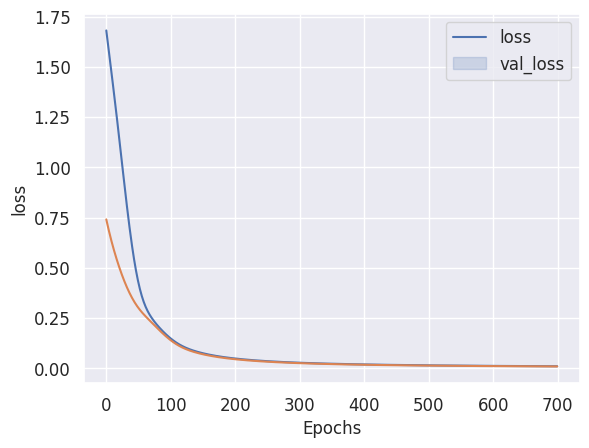

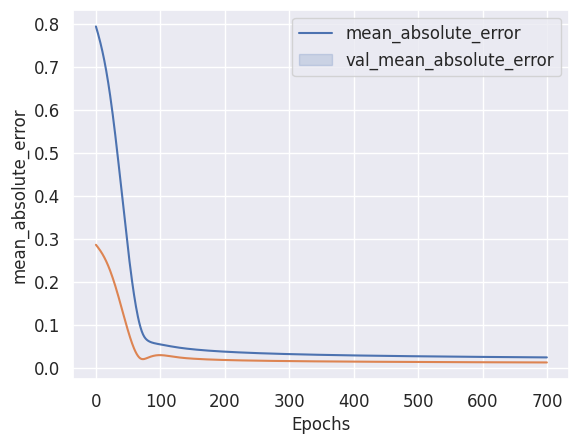

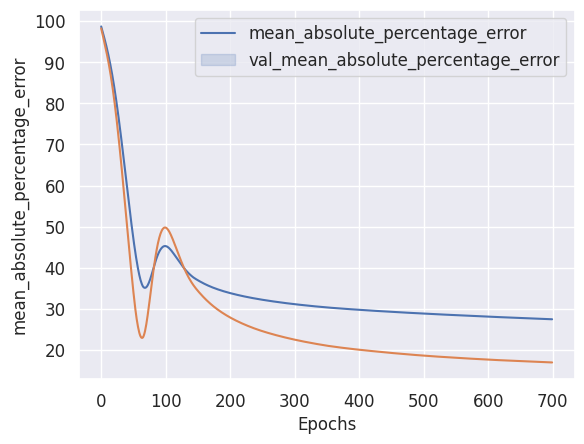

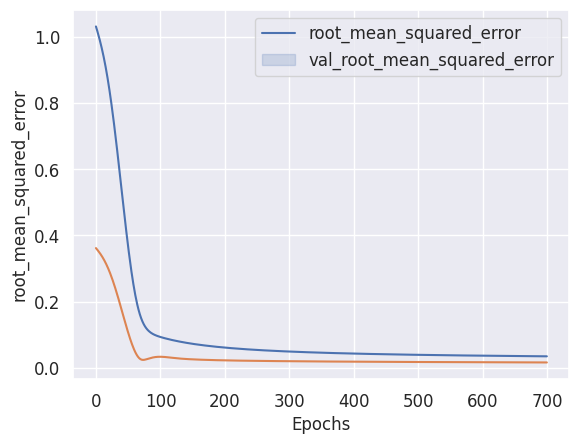

In [10]:
#training dataset
train_loss, train_RMSE, train_MAE, train_MAPE = model.evaluate(x_train, y_train)

print('\n','Evaluation of Training dataset:','\n''\n','train_loss:',round(train_loss,3),'\n','train_RMSE:',round(train_RMSE,3),'\n', 'train_MAE:',round(train_MAE,3),'\n','train_MAPE:',round(train_MAPE,3))


#val dataset
val_loss, val_RMSE, val_MAE, val_MAPE = model.evaluate(x_test, y_test)
print('\n','Evaluation of Testing dataset:','\n''\n','val_loss:',round(val_loss,3),'\n','val_RMSE:',round(val_RMSE,3),'\n', 'val_MAE:',round(val_MAE,3),'\n','val_MAPE:',round(val_MAPE,3))

# predict on val set



mlflow.log_metric('train_loss',train_loss)
mlflow.log_metric('RMSE', train_RMSE)
mlflow.log_metric('MAE', train_MAE)
mlflow.log_metric('MAPE',train_MAPE)

mlflow.log_metric('val_loss',val_loss)
mlflow.log_metric('val_RMSE', val_RMSE)
mlflow.log_metric('val_MAE', val_MAE)
mlflow.log_metric('val_MAPE',val_MAPE)

mlflow.keras.save_model(model, path =path_model+'/')

path_metrics+'/'+'data.csv'
df = pd.read_csv(path_metrics+'/'+'data.csv')

metricplot(df, 'epoch', 'loss','val_loss', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_error','val_mean_absolute_error', path_metrics)
metricplot(df, 'epoch', 'mean_absolute_percentage_error','val_mean_absolute_percentage_error', path_metrics)
metricplot(df, 'epoch', 'root_mean_squared_error','val_root_mean_squared_error', path_metrics)

In [11]:
y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(y_test, y_test_pred).numpy(),3))

32/32 [==============================] - 1s 1ms/step
The MAPE on the test data is: 16.967


In [15]:
model.save(path_model+'/'+model_name)   
#model_name = 'lstm_128.h5'
#path_model_tr ="../Model_Outputs/2022_11_01/best_fit5/model_Bilstm/model" 
model_eval = load_model(path_model+'/'+model_name, compile=False)

# get future dates and predict the future close price!
future_days = 10

startdate = list(df_datetime['date'])[-1]
startdate = pd.to_datetime(startdate) + pd.DateOffset(days=1)
enddate = pd.to_datetime(startdate) + pd.DateOffset(days=future_days+1)
forecasting_dates= pd.bdate_range(start=startdate, end=enddate, freq = 'B')
number_of_days = len(forecasting_dates)
forecast = model_eval.predict(train_data_X[-len(forecasting_dates):])
forecast_copies = np.repeat(forecast, df_data.shape[1], axis = -1 )
y_pred_fut = scaler.inverse_transform(forecast_copies)[:,0]
forecast_close = {'dates':forecasting_dates ,'close': y_pred_fut, 'close_orig':data['open'].iloc[-number_of_days:] }
forecasting_df = pd.DataFrame(data = forecast_close)
forecasting_df.to_csv(path_forecast +'/'+ 'forecast.csv')
print('The forecast for the future',number_of_days,'days is:','\n',forecasting_df)

1/1 [==============================] - 1s 615ms/step
The forecast for the future 8 days is: 
           dates     close  close_orig
9992 2022-11-02  0.976775     0.97837
9993 2022-11-03  0.978627     0.98730
9994 2022-11-04  0.984140     0.98734
9995 2022-11-07  0.990109     0.99610
9996 2022-11-08  1.000711     1.00783
9997 2022-11-09  0.999843     0.99642
9998 2022-11-10  0.994395     0.99465
9999 2022-11-11  0.989248     0.98724


In [16]:
#y_test_pred = model.predict(x_test)
MAPE_pred = tf.keras.losses.MeanAbsolutePercentageError()
print("The MAPE on the test data is:",round(MAPE_pred(forecasting_df['close'], forecasting_df['close_orig']).numpy(),3),"%")

The MAPE on the test data is: 0.408 %


<AxesSubplot: xlabel='dates', ylabel='close'>

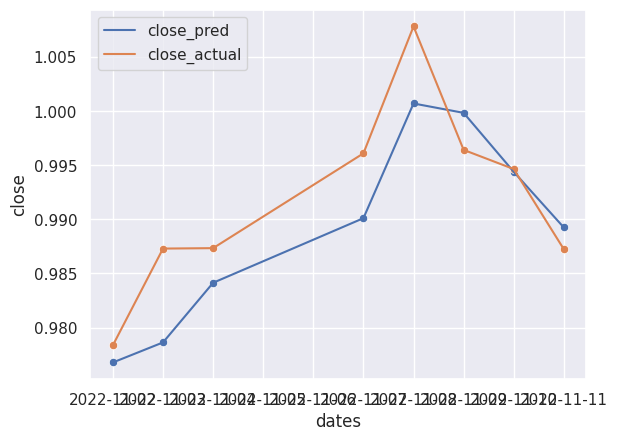

In [17]:
sns.lineplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'], label='close_pred')
sns.scatterplot(data = forecasting_df, x  = forecasting_df['dates'], y = forecasting_df['close'])

sns.lineplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'],label='close_actual')
sns.scatterplot(data = forecasting_df, x = forecasting_df['dates'], y = forecasting_df['close_orig'])